In [1]:
def radial2(gal, ext, xcen, ycen, rst, q, pa, delr=0.5, rmax=30, norm=True, rms=False):
    '''
    Parameters
    ----------
    ext : int
        Fits extension number
    delr : float
        in pixel
    rmax : float
        in pixel
    rcalc : float
        radius at which stellar mass is calculated.
    rms : bool
        is input a rms map?
    
    Returns
    -------
    r : float array
        radius. in pixel.
    f : float array
        flux, in units of counts/pixel.
        
    Notes
    -----
    Radius that is retured from this starts with delr/2.
    '''
    
    hdu = fits.open(gal)
    sci = hdu[ext].data[int(ycen-rst/2.):int(ycen+rst/2.)-1, int(xcen-rst/2.):int(xcen+rst/2.)-1]
    if rms:
        sci[:,:] = sci[:,:]**2
        
    hdu.close()
    if norm:
        sci /= np.sum(sci)

    rn = np.arange(0,rmax/delr,1)
    r  = rn * delr + delr/2.
    f  = r * 0
    n  = r * 0
    ef = r * 0
    fs = r * 0 # sky
    ns = r * 0

    fpeak = 0
    xcen1, ycen1 = rst/2., rst/2.

    flag = sci*0
    contmp = (flag == 0)
    flag_f = flag[contmp]
    xx = flag_f * 0
    yy = flag_f * 0
    rr = flag_f * 0

    contmp = (flag == 0)
    sci_f = sci[contmp]

    for jj in range(len(sci[:,0])):
        for ii in range(len(sci[0,:])):
            ji = jj*len(sci[:,0]) + ii
            xx[ji] = ii
            yy[ji] = jj

            if ii - xcen1 != 0:
                th = math.atan((jj-ycen1)/(ii-xcen1))
            elif (jj-ycen1)>0:
                th = pi/2.
            elif (jj-ycen1)<0:
                th = pi*3./2.

            Cq = get_ellipse_coords(a=1.0, b=q, x=0.0, y=0.0, angle=-pa+pi/2., theta=th) # Correction for axis ratio.
            rtmp = np.sqrt((jj-ycen1)**2 + (ii-xcen1)**2) * Cq

            rr[ji] = rtmp

    for kk in range(len(r)):
        conr = (rr >= r[kk]) & (rr < r[kk]+delr) &\
               (rr < rmax)
        f[kk] = np.sum(sci_f[conr])
        n[kk] = len(sci_f[conr])

        if n[kk]>0:
            f[kk] /= n[kk]

    if norm:
        sum = 0
        for kk in range(len(r)):
            if r[kk]<rmax:
                sum += 2 * np.pi * r[kk] * f[kk] * delr
        if sum>0:
            f /= sum
        else:
            print('Sum is %.2f'%(sum))
            print('Normalization failed.')

    if rms:
        f = np.sqrt(f)
            
    return r, f




In [2]:
def get_ellipse_coords(a=0.0, b=0.0, x=0.0, y=0.0, angle=0.0, theta=0):
    """ Draws an ellipse using (360*k + 1) discrete points; based on pseudo code
    given at http://en.wikipedia.org/wiki/Ellipse
    k = 1 means 361 points (degree by degree)
    a = major axis distance,
    b = minor axis distance,
    x = offset along the x-axis
    y = offset along the y-axis
    angle = clockwise rotation [in degrees] of the ellipse;
        * angle=0  : the ellipse is aligned with the positive x-axis
        * angle=30 : rotated 30 degrees clockwise from positive x-axis
    """

    beta = -angle * np.pi/180.0
    sin_beta = np.sin(beta)
    cos_beta = np.cos(beta)
    #alpha = np.radians(np.r_[0.:360.:1j*(360*k+1)])
    alpha = theta

    sin_alpha = np.sin(alpha)
    cos_alpha = np.cos(alpha)

    #pts[:, 0] = x + (a * cos_alpha * cos_beta - b * sin_alpha * sin_beta)
    #pts[:, 1] = y + (a * cos_alpha * sin_beta + b * sin_alpha * cos_beta)
    xx = x + (a * cos_alpha * cos_beta - b * sin_alpha * sin_beta)
    yy = y + (a * cos_alpha * sin_beta + b * sin_alpha * cos_beta)

    C = 1./np.sqrt(xx**2+yy**2)

    return C



In [13]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import sys
import os
from astropy.cosmology import FlatLambdaCDM
from astropy.modeling.functional_models import Sersic1D as Ser
import matplotlib.cm as cm
import math
pi = np.pi

from astropy.cosmology import FlatLambdaCDM
import numpy as np

import numpy as np
import matplotlib
from scipy import stats
import math
# matplotlib.use("Agg")
# matplotlib.rcParams['font.family'] = 'Times New Roman'
import matplotlib.pyplot as mplt
import pandas as pd
from astropy.cosmology import WMAP9 as cosmo
from astropy import constants as const
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy import units as u
from astropy.table import Table
from astropy.table import Table
from matplotlib import rcParams
from matplotlib.pyplot import MultipleLocator

#data = Table.read('truesource_lenstruction_new_master_matchedwithmiri_z0p5_noimportpsf.csv')

cur_dir='/Users/liuzhaoran/Desktop/miri/radial_profile/'
data_new = Table.read('pah_0302newpsfgoodsed_re_allmiriband_hotmode.csv')
sed_new = Table.read('goodsed_results_0113.fits')
#sed_old = Table.read('results_allband_0103.fits')
#galfit = Table.read('galfit_re.csv')
len(sed_new)
index_sed = []
for i in range(len(sed_new)):
    for j in range(len(data_new)):
        if sed_new['id'][i]==data_new['id'][j]:
            index_sed.append(i)
sed_new = sed_new[index_sed]


sed = sed_new
data = data_new


import glob
datafits_all=sorted(glob.glob('/Users/liuzhaoran/Documents/CIGALE/MIRI/miri_object/out/*model.fits'))
number = []
import re
for i in range(len(datafits_all)):
    a = re.findall(r"\d+\.?\d*",datafits_all[i])
    number.append([int(num) for num in a])
    new_number = [];
for n in number:
    new_number.append(int(np.array(n)));
number = new_number

index_sed_all = []
for i in range(len(number)):
    for j in range(len(sed)):
        if number[i] == sed[j]['id']:
            index_sed_all.append(i)
            
            
datafits_new = []
for i in range(len(datafits_all)):
    for j in range(len(index_sed_all)):
        if i == index_sed_all[j]:
            datafits_new.append(datafits_all[i])
            
    
    
#######calculate the dust fraction#####
#######calculate the dust fraction#####
stellar_200 = []
stellar_old_200 = []
stellar_young_200 = []
stellar_aver_200 = []
for i in range(len(datafits_new)):
    best_model_sed = Table.read(datafits_new[i])
    index_wavelength = np.where((best_model_sed['wavelength']>=1759.5)&(best_model_sed['wavelength']<=2220.5))[0]
    dust = best_model_sed['dust'][index_wavelength]
   # stellar_all = best_model_sed[index_wavelength]['stellar.old']+best_model_sed[index_wavelength]['stellar.young']+best_model_sed[index_wavelength]['attenuation.stellar.old']+ best_model_sed[index_wavelength]['attenuation.stellar.young']+best_model_sed[index_wavelength]['igm']
    fraction = dust/best_model_sed[index_wavelength]['L_lambda_total']
    flux_200 = best_model_sed[index_wavelength]['Fnu']*(1-fraction)
    stellar_old_all = best_model_sed[index_wavelength]['stellar.old']+best_model_sed[index_wavelength]['attenuation.stellar.old']
    stellar_young_all = best_model_sed[index_wavelength]['stellar.young']+best_model_sed[index_wavelength]['attenuation.stellar.young']
    stellar_old_200.append(np.sum(stellar_old_all))
    stellar_young_200.append(np.sum(stellar_young_all))
    dust_all =  best_model_sed[index_wavelength]['dust']
  #  stellar_200.append(np.sum(stellar_all))
    stellar_aver_200.append(np.average(flux_200))
    
    
    
    
#######calculate the dust fraction#####
stellar_770 = []
stellar_old_770 = []
stellar_young_770 = []
stellar_aver_770 = []
for i in range(len(datafits_new)):
    best_model_sed = Table.read(datafits_new[i])
    index_wavelength = np.where((best_model_sed['wavelength']>=6600)&(best_model_sed['wavelength']<=8800))[0]
    dust = best_model_sed['dust'][index_wavelength]
   # stellar_all = best_model_sed[index_wavelength]['stellar.old']+best_model_sed[index_wavelength]['stellar.young']+best_model_sed[index_wavelength]['attenuation.stellar.old']+ best_model_sed[index_wavelength]['attenuation.stellar.young']+best_model_sed[index_wavelength]['igm']
    fraction = dust/best_model_sed[index_wavelength]['L_lambda_total']
    flux = best_model_sed[index_wavelength]['Fnu']*(1-fraction)
    stellar_old_all = best_model_sed[index_wavelength]['stellar.old']+best_model_sed[index_wavelength]['attenuation.stellar.old']
    stellar_young_all = best_model_sed[index_wavelength]['stellar.young']+best_model_sed[index_wavelength]['attenuation.stellar.young']
    stellar_old_770.append(np.sum(stellar_old_all))
    stellar_young_770.append(np.sum(stellar_young_all))
  #  stellar_770.append(np.sum(stellar_all))
    stellar_aver_770.append(np.average(flux))



    
    

# stellar_1000 = []
# stellar_old_1000 = []
# stellar_young_1000 = []
# stellar_aver_1000 = []
# for i in range(len(datafits_new)):
#     best_model_sed = Table.read(datafits_new[i])
#     index_wavelength = np.where((best_model_sed['wavelength']>=9000)&(best_model_sed['wavelength']<=10000))[0]
#     stellar_all = best_model_sed[index_wavelength]['stellar.old']
#     +best_model_sed[index_wavelength]['stellar.young']
#     +best_model_sed[index_wavelength]['attenuation.stellar.old']
#     + best_model_sed[index_wavelength]['attenuation.stellar.young']
#     +best_model_sed[index_wavelength]['igm']
#     stellar_old_all = best_model_sed[index_wavelength]['stellar.old']+best_model_sed[index_wavelength]['attenuation.stellar.old']
#     stellar_young_all = best_model_sed[index_wavelength]['stellar.young']+best_model_sed[index_wavelength]['attenuation.stellar.young']
#     stellar_old_1000.append(np.sum(stellar_old_all))
#     stellar_young_1000.append(np.sum(stellar_young_all))
#     stellar_1000.append(np.sum(stellar_all))
#     stellar_aver_1000.append(np.average(stellar_all))

stellar_1000 = []
stellar_old_1000 = []
stellar_young_1000 = []
stellar_aver_1000 = []
for i in range(len(datafits_new)):
    best_model_sed = Table.read(datafits_new[i])
    index_wavelength = np.where((best_model_sed['wavelength']>=9000)&(best_model_sed['wavelength']<=10000))[0]
    stellar_all = best_model_sed[index_wavelength]['stellar.old']
    +best_model_sed[index_wavelength]['stellar.young']
    +best_model_sed[index_wavelength]['attenuation.stellar.old']
    + best_model_sed[index_wavelength]['attenuation.stellar.young']
    +best_model_sed[index_wavelength]['igm']
    stellar_old_all = best_model_sed[index_wavelength]['stellar.old']+best_model_sed[index_wavelength]['attenuation.stellar.old']
    stellar_young_all = best_model_sed[index_wavelength]['stellar.young']+best_model_sed[index_wavelength]['attenuation.stellar.young']
    stellar_old_1000.append(np.sum(stellar_old_all))
    stellar_young_1000.append(np.sum(stellar_young_all))
    stellar_1000.append(np.sum(stellar_all))
    stellar_aver_1000.append(np.average(stellar_all))

ratio_2_7 = np.array(stellar_aver_200)/np.array(stellar_aver_770)
ratio_2_10 = np.array(stellar_aver_200)/np.array(stellar_aver_1000)

/var/folders/kl/kvr8wgvd6_z3gsnb2p117kwh0000gn/T/ipykernel_5158/3462216019.py:83: RuntimeWarning: invalid value encountered in log10
  f_phys_770 = -2.5*np.log10(f_770 / area_770) + 28.902822029188933
/var/folders/kl/kvr8wgvd6_z3gsnb2p117kwh0000gn/T/ipykernel_5158/3462216019.py:84: RuntimeWarning: invalid value encountered in log10
  f_phys_1000 = -2.5*np.log10(f_1000 / area_1000) + 28.902822029188933
/var/folders/kl/kvr8wgvd6_z3gsnb2p117kwh0000gn/T/ipykernel_5158/3462216019.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(nrows=2,ncols=1,sharex=True,figsize=(8,6))


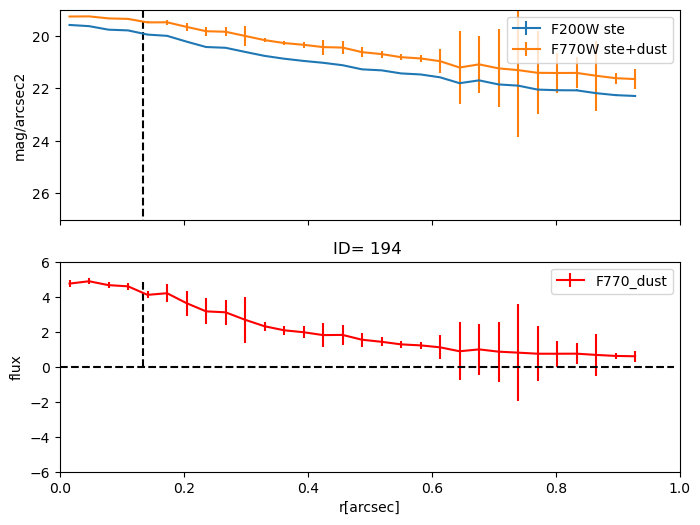

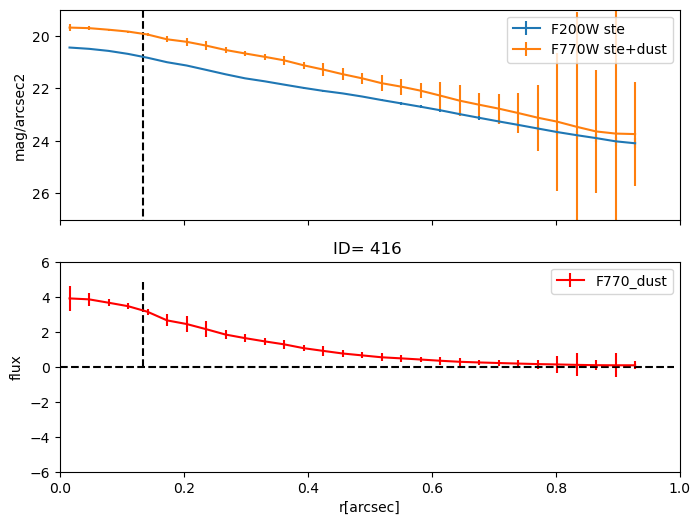

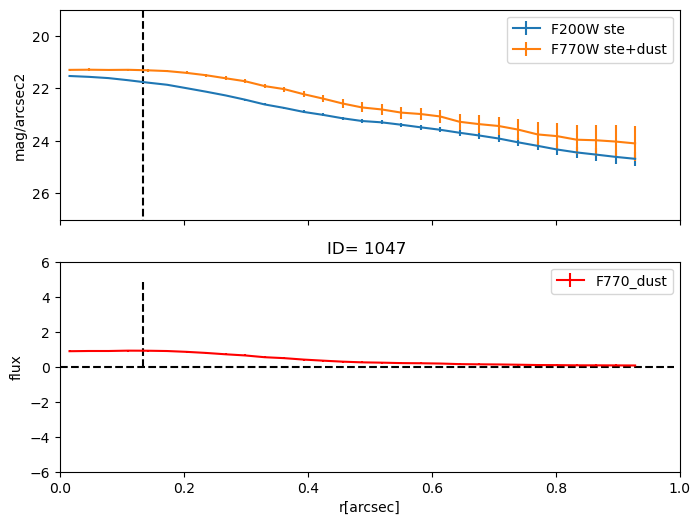

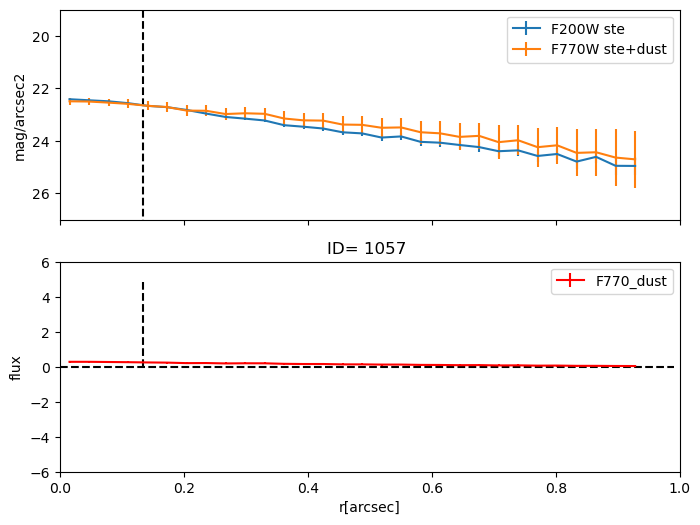

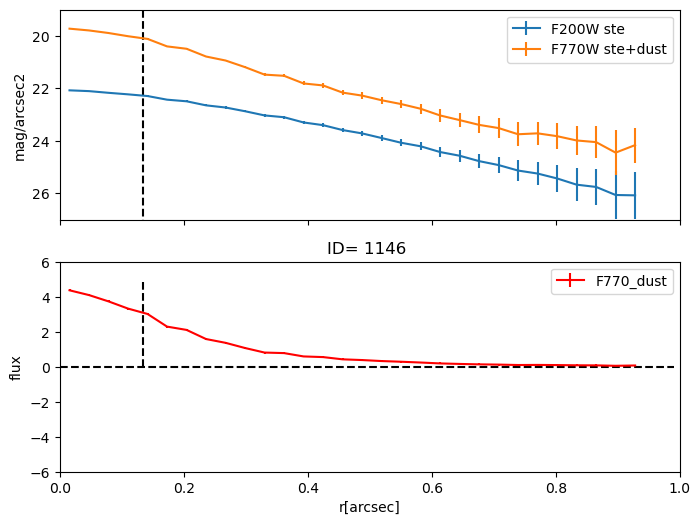

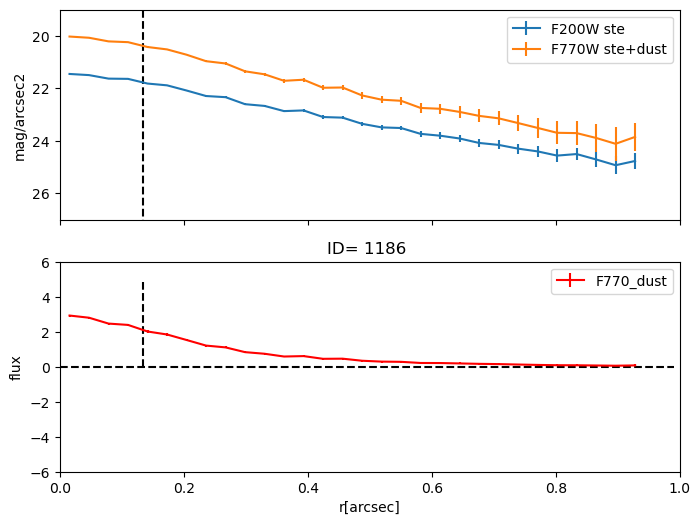

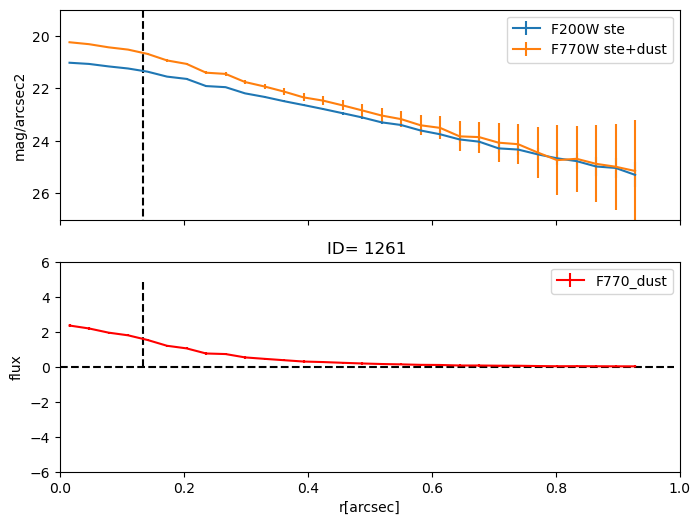

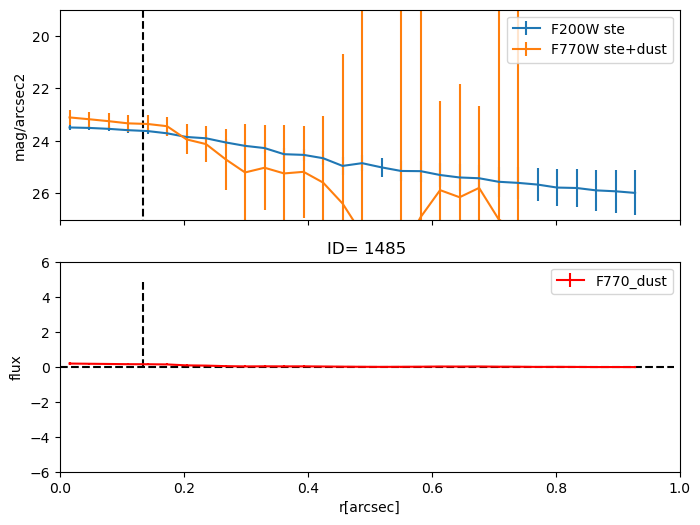

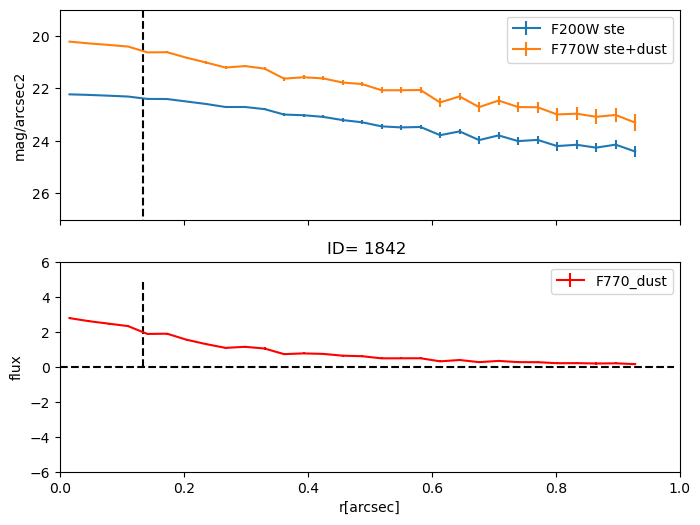

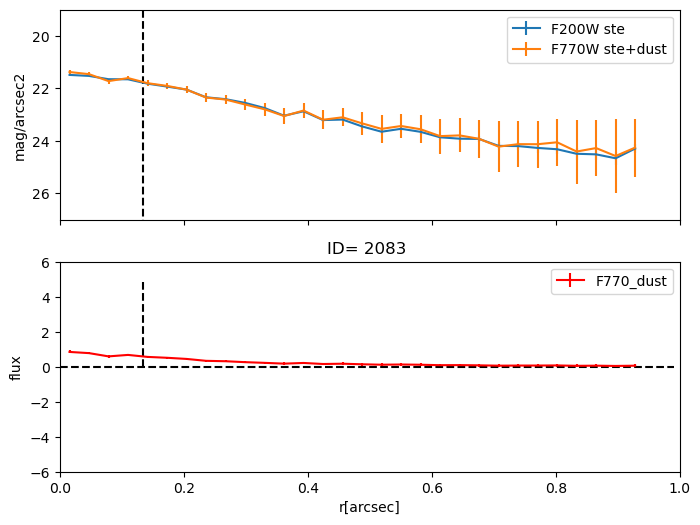

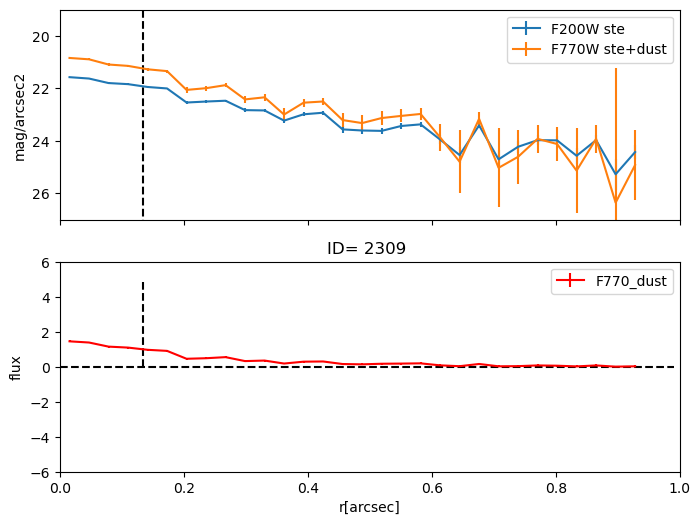

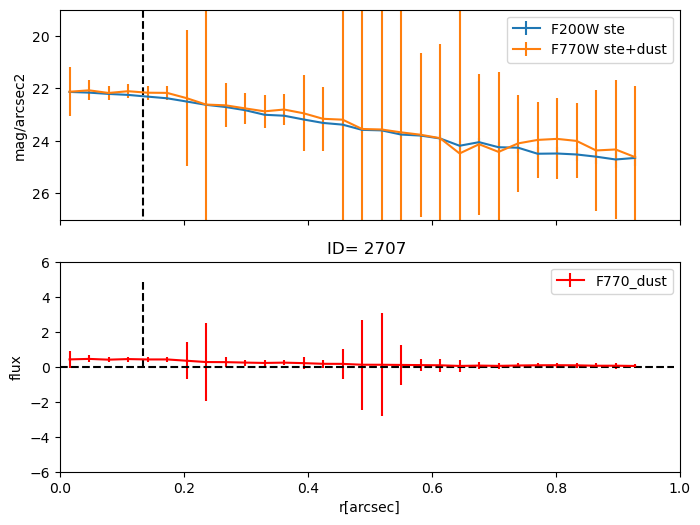

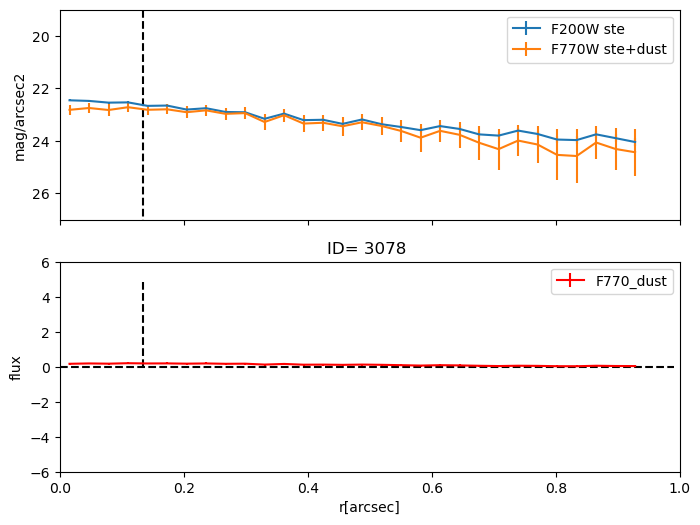

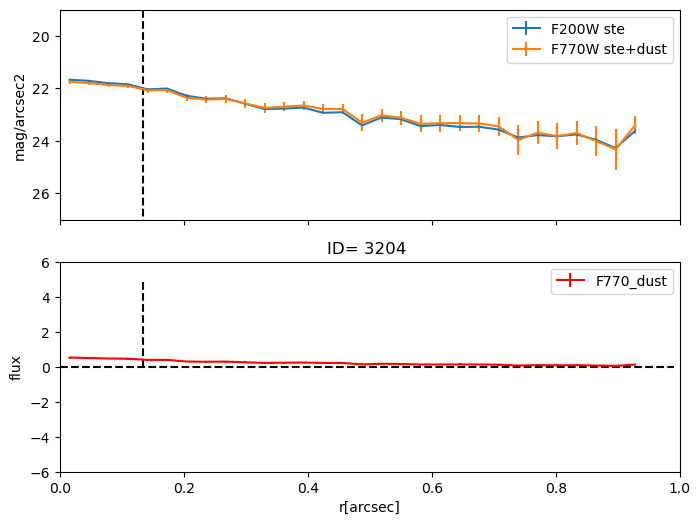

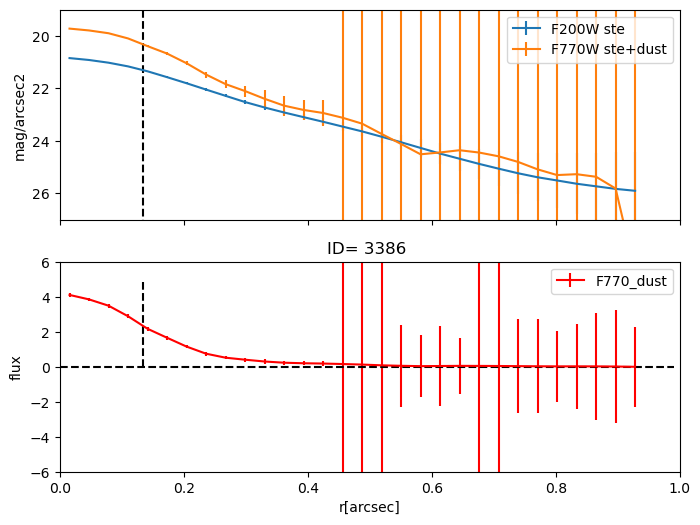

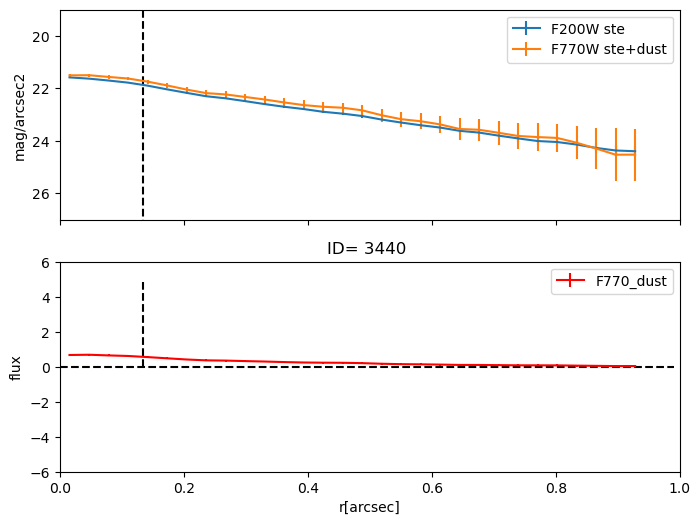

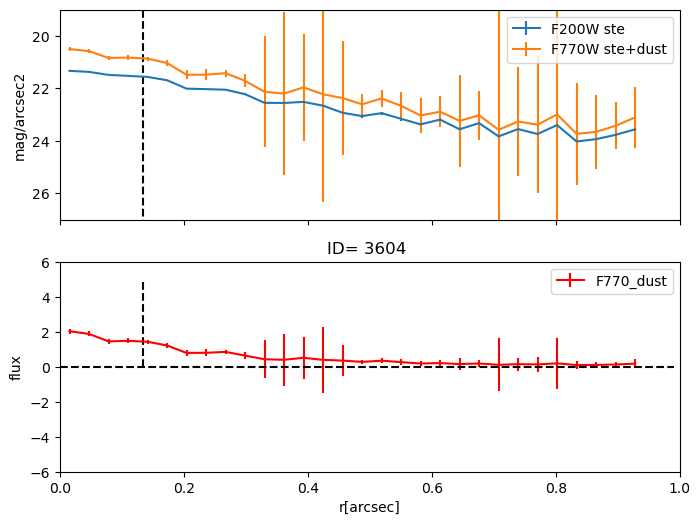

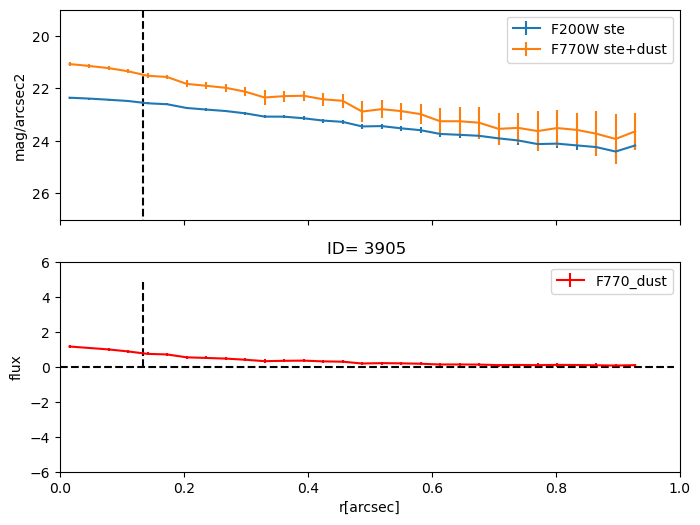

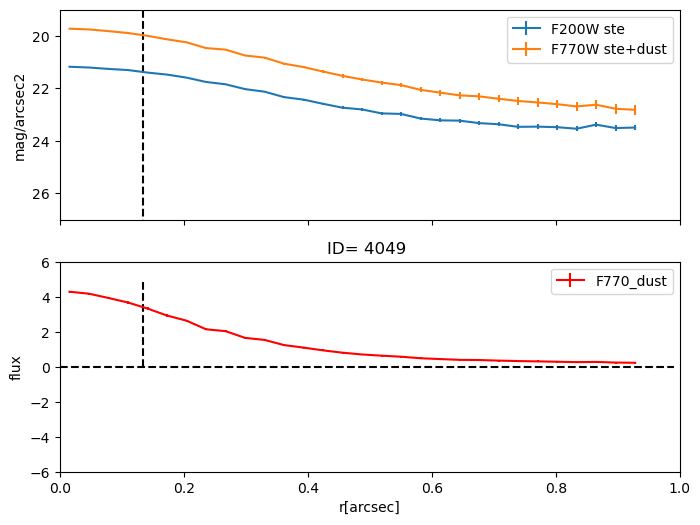

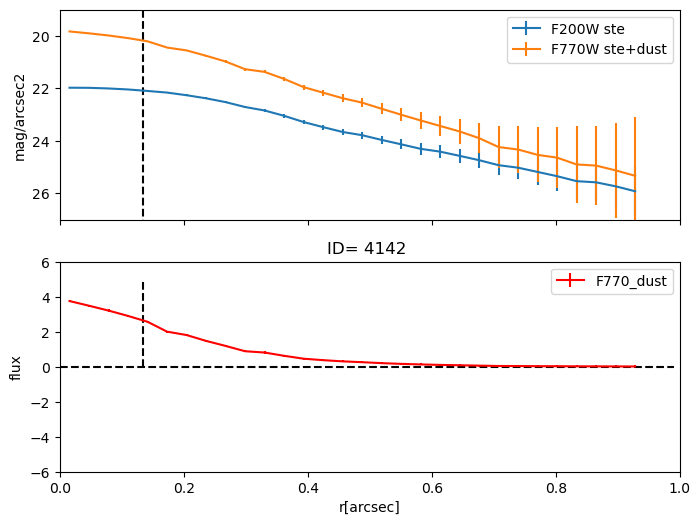

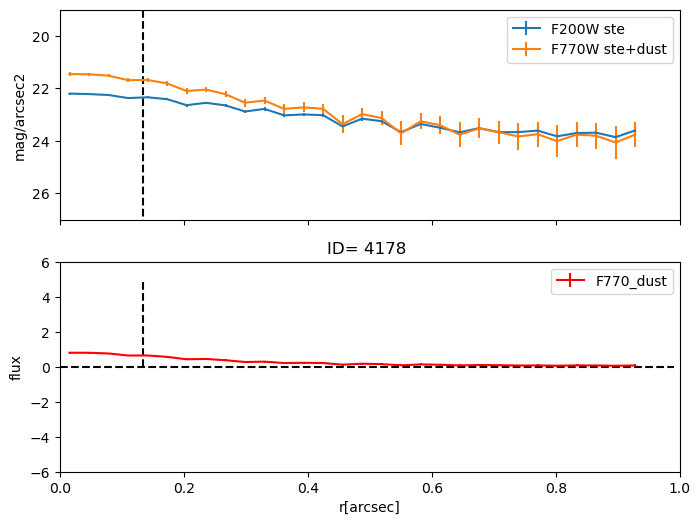

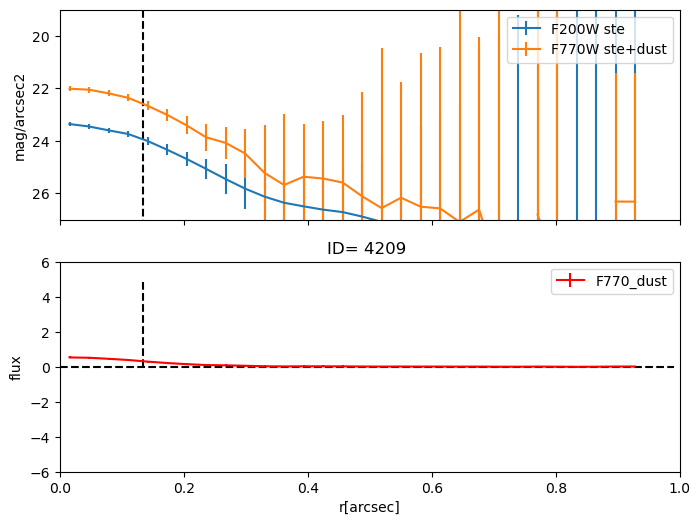

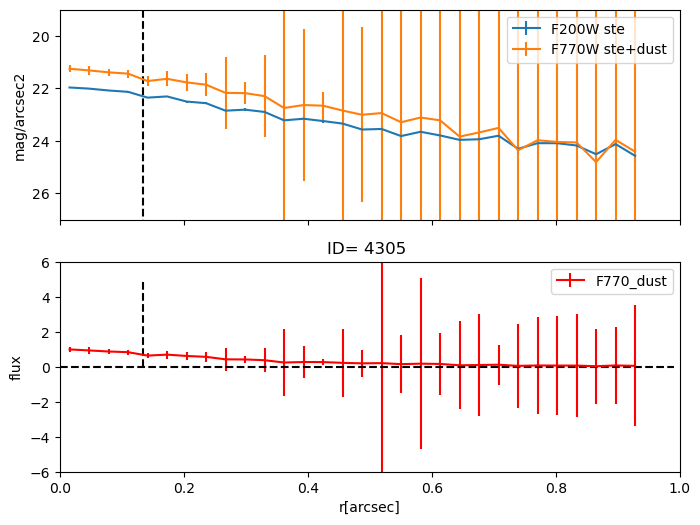

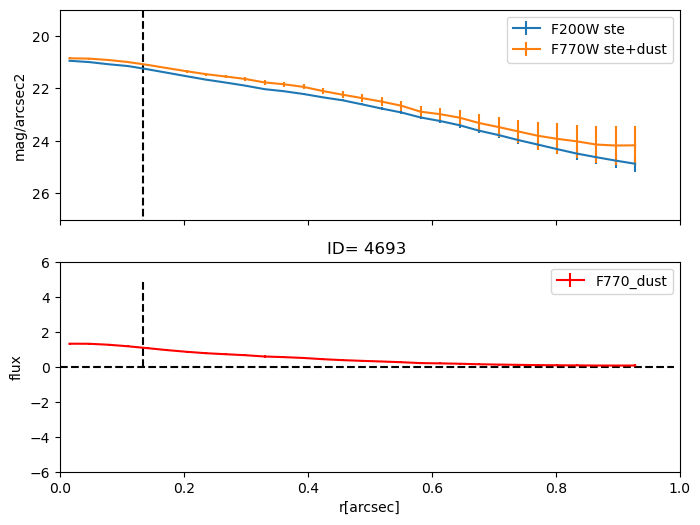

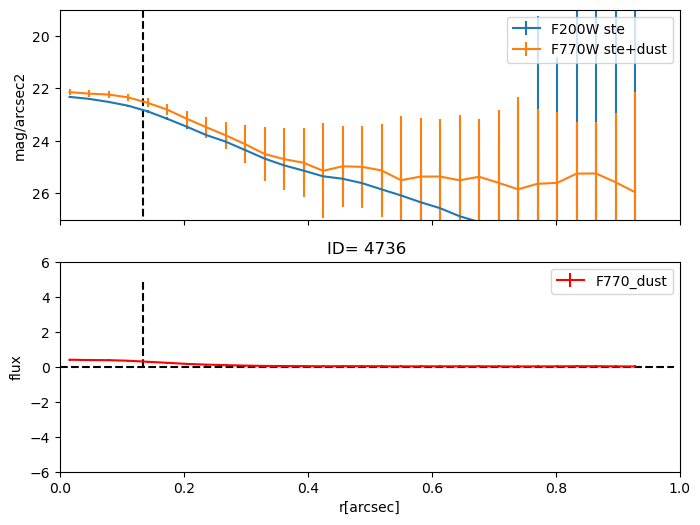

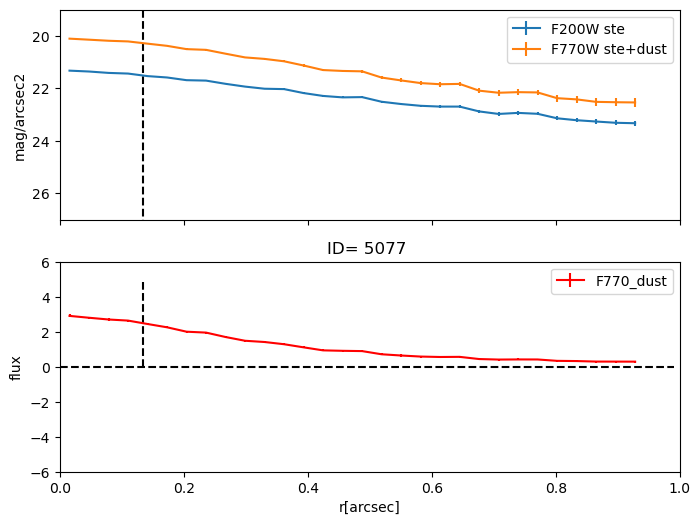

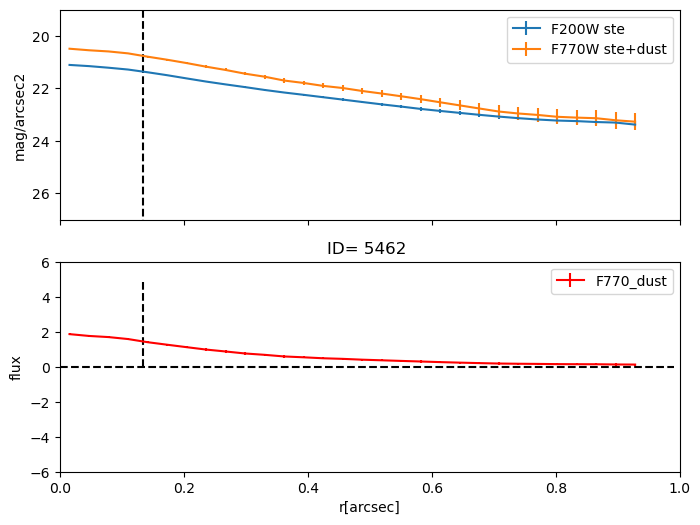

In [292]:
in_total_ratio_dust_2d = []
in_total_ratio_dust_err_2d = []
in_total_ratio_stellar_2d = []
in_total_ratio_stellar_err_2d = []
test_pixel_2D = []
outer_pixel_2D = []

for k in range(len(data)):
#for k in range(1):
    #k = 7
    nircam200_all = sorted(glob.glob('/Users/liuzhaoran/Desktop/miri/radial_profile/*770psf_200_100_100.fits'))
    miri770_all = sorted(glob.glob('/Users/liuzhaoran/Desktop/miri/radial_profile/*770_100_100_sci.fits'))
    miri1000_all = sorted(glob.glob('/Users/liuzhaoran/Desktop/miri/radial_profile/*1000_100_100_sci.fits'))
    ext = 0
    gal_200 = nircam200_all[k]
    gal_770 = miri770_all[k]
    gal_1000 = miri1000_all[k]
    hd0_gal_200 = fits.open(gal_200)[0].header
    hd0_gal_770 = fits.open(gal_770)[0].header
    hd0_gal_1000 = fits.open(gal_1000)[0].header
    
    
    
    #@@@ If you do not have the following, find out from e.g., SExtractor catalog. 

    # xcen = float(hd_gal['2_XC'].split(' ')[0])
    # ycen = float(hd_gal['2_YC'].split(' ')[0])
    xcen = float(50.0)
    ycen = float(50.0)
    # rst = int(hd_gal['NAXIS1'])
    #q = float(hd_gal['2_AR'].split(' ')[0])
    #pa = float(hd_gal['2_PA'].split(' ')[0])
    # delr = 1.0
    rst = int(100)
    q = data['b_image_JWST_NIRCAM_MULTIPLE_F200W'][k]/data['a_image_JWST_NIRCAM_MULTIPLE_F200W'][k]
    pa_200 = data['theta_JWST_NIRCAM_MULTIPLE_F200W'][k]
#     pa_770 = data['theta_1000'][k]
#     pa_1000 =data['theta_1000'][k]
    delr = 1

    # pa_200 = pa_200 + 90
    r_200, f_200 = radial2(gal_200, ext, xcen, ycen, rst, q, pa_200, delr=delr, rmax=30, norm=False)
    r_770, f_770 = radial2(gal_770, ext, xcen, ycen, rst, q, pa_200, delr=delr, rmax=30, norm=False)
    r_1000, f_1000 = radial2(gal_1000, ext, xcen, ycen, rst, q, pa_200, delr=delr, rmax=30, norm=False)
    # RMS;
    rms200_all = sorted(glob.glob('/Users/liuzhaoran/Desktop/miri/radial_profile/*200_100_100_rms.fits'))
    rms770_all = sorted(glob.glob('/Users/liuzhaoran/Desktop/miri/radial_profile/*770_100_100_rms.fits'))
    rms1000_all = sorted(glob.glob('/Users/liuzhaoran/Desktop/miri/radial_profile/*1000_100_100_rms.fits'))


    gal_200 = rms200_all[k]
    gal_770 = rms770_all[k]
    gal_1000 = rms1000_all[k]
    # gal_200 = '2707_rms_200_100_100.fits'
    # gal_770 = '2707_rms_770_100_100.fits'
    # gal_1000 = '2707_rms_1000_100_100.fits'
    ext = 0
    _, ef_200 = radial2(gal_200, ext, xcen, ycen, rst, q, pa_200, delr=delr, rmax=30, norm=False, rms=True)

    _, ef_770 = radial2(gal_770, ext, xcen, ycen, rst, q, pa_200, delr=delr, rmax=30, norm=False, rms=True)
    _, ef_1000 = radial2(gal_1000, ext, xcen, ycen, rst, q, pa_200, delr=delr, rmax=30, norm=False, rms=True)
    
    
    magzp_200 = 28.000411294150283
    magzp_770 = 28.902822029188933 
    fig, axes = plt.subplots(nrows=2,ncols=1,sharex=True,figsize=(8,6)) 
    # add a subplot with no frame
    #ax2 = plt.subplot(222, frameon=False)
    axes1= axes[0]
    axes2= axes[1]

    #plt.yscale("log")
    pix_200 = 0.031456 # pixel scale
    area_200 = pix_200**2 # arcsec2
    pix_770 = 0.031456 # pixel scale
    area_770 = pix_770**2 # arcsec2
    pix_1000 = 0.031456 # pixel scale
    area_1000 = pix_1000**2 # arcsec2
    #f_phys_200 = -2.5*np.log10(f_200 / area) + 28.000411294150283# mag / arcsec2
    f_dust_770 = f_770 - f_200/ratio_2_7[k]
    f_dust_1000 = f_1000 - f_200/ratio_2_10[k]
    f_phys_200 = -2.5*np.log10(f_200 / area_200) + 28.000411294150283
    f_phys_770 = -2.5*np.log10(f_770 / area_770) + 28.902822029188933 
    f_phys_1000 = -2.5*np.log10(f_1000 / area_1000) + 28.902822029188933 

    ###error###
    f_dust_770_r = np.sqrt(ef_770**2 + ef_200**2/(ratio_2_7[k]**2))
    f_dust_1000_r = np.sqrt(ef_1000**2 + ef_200**2/(ratio_2_10[k]**2))


    sn_200 = np.abs(f_200) / np.abs(ef_200)
    ef_phys_200 = 1/sn_200 # mag / arcsec2
    sn_770 = np.abs(f_770) / np.abs(ef_770)
    ef_phys_770 = 1/sn_770 # mag / arcsec2
    sn_1000 = np.abs(f_1000) / np.abs(ef_1000)
    ef_phys_1000 = 1/sn_1000 # mag / arcsec2
    axes1.errorbar(r_200*0.031456, f_phys_200 , yerr= 0.5*ef_phys_200, label = 'F200W ste')
    axes1.errorbar(r_770*0.031456, f_phys_770 , yerr=0.5* ef_phys_770, label = 'F770W ste+dust')
 #   axes1.errorbar(r_1000*0.0251, f_phys_1000 , yerr= 0.5*ef_phys_1000, label = 'F1000W ste+dust')
    #plt.errorbar(r_770*0.0251, f_phys_1000 , yerr= ef_phys_1000, label = 'F1000W ste+dust')
    axes2.errorbar(r_770*0.031456, f_dust_770 , yerr= 0.5*f_dust_770_r,label = 'F770_dust', color = 'red')
    #axes2.errorbar(r_770*0.0251, f_dust_1000 , yerr= f_dust_1000_r,label = 'F1000_dust', color = 'purple')
    #axes2.errorbar(r_770*0.0251, f_200 , yerr=0.5* ef_200,label = 'F200_stellar', color = 'black')
  #  axes1.plot([0.328, 0.328], [15,30] ,'--',color = 'black')
    axes1.plot([0.269/2, 0.269/2], [15,30] ,'--',color = 'black')
   # axes2.plot([0.328, 0.328], [0,5] ,'--',color = 'black')
    axes2.plot([0.269/2, 0.269/2], [0,5] ,'--',color = 'black')
    #plt.errorbar(r_770*0.04, f_phys_770 , yerr= ef_phys_770, label = 'F770W ste+dust')
    #plt.errorbar(r_1000*0.04, f_phys_1000, yerr= ef_phys_1000, label = 'F1000W')
    #plt.errorbar(np.log10(r_770), f_phys_770-f_phys_200, yerr=ef_phys_770, label = 'F770W')
    axes2.set_xlabel('r[arcsec]')
    axes2.set_ylabel('flux')
    axes1.set_ylabel('mag/arcsec2')
    axes1.set_ylim(27, 19)
    #axes1.set_ylim(38, 18)
    axes2.set_ylim(-6, 6)
    xx = np.arange(0, 1, 0.01)
    axes2.plot(xx, xx*0 ,'--',color = 'black')
    title = "ID= %s " %(data['idalp'][k])
    plt.title(title)

    plt.xlim(0, 1)
    axes2.legend()
    axes1.legend()
    
    
    for j in range(len(r_200)):
        if f_dust_770[j] <=0:
            f_dust_770[j] = 0
        if f_200[j] <= 0:
            f_200[j] = 0
    
    ###Correct for redshift effect and lensing magnification###
    ####denination of inner region: 1kpc, trace the bulge formation###
    d_A = cosmo.angular_diameter_distance(z=data['zbest'][k]).value
    theta = 1/1000/d_A/pi * 180 * 3600*data['magnification'][k]
    pixel = theta/0.031456
    inner_region_pixel = math.ceil(pixel)
    test_pixel_2D.append(inner_region_pixel)
    
    snr = np.array(f_770)/np.array(ef_770)
    for i in range(len(snr)):
        if i <= 1 :
            i=i
        elif snr[i-1]>=1 and snr[i-2]>=1:
            outer_pixel = i
    outer_pixel_2D.append(outer_pixel)
    

    
    #calculate the flux ratio in 10 pixels and out 10 pixels
    #here is the flux! not flux density!
    fluxdust_total_in = []
    fluxstellar_total_in = []
    flux_dust_error_in = []
    flux_stellar_error_in = []
    area = []
    for i in range(inner_region_pixel):
        r1 = r_200[i]
        r2 = r_200[i]*q
        r_e_2 = r1*r2
        index_in = np.arange(0, inner_region_pixel, 1, dtype = None)
        wi_in_dust = 1/(f_dust_770_r[index_in]*f_dust_770_r[index_in])
        wi_in_stellar = 1/(f_dust_770_r[index_in]*f_dust_770_r[index_in])
        if i == 0:
            flux_circle = f_dust_770[i]*pi*r_e_2*wi_in_dust[i]
            error_circle = f_dust_770_r[i]*pi*r_e_2
            flux_circle_stellar = f_200[i]*pi*r_e_2*wi_in_stellar[i]
            error_circle_stellar = ef_200[i]*pi*r_e_2
        else:
            r1_o = r_200[i-1]
            r2_o = r_200[i-1]*q
            r_e_2_o = r1_o*r2_o
            flux_circle = f_dust_770[i]*pi*r_e_2*wi_in_dust[i] - f_dust_770[i]*pi*r_e_2_o*wi_in_dust[i]
            error_circle_stellar = ef_200[i]*pi*r_e_2 - ef_200[i]*pi*r_e_2_o
            flux_circle_stellar = f_200[i]*pi*r_e_2*wi_in_stellar[i] - f_200[i]*pi*r_e_2_o*wi_in_stellar[i]
            error_circle = f_dust_770_r[i]*pi*r_e_2 - f_dust_770_r[i]*pi*r_e_2_o
        fluxdust_total_in.append(flux_circle)
        fluxstellar_total_in.append(flux_circle_stellar)
        flux_dust_error_in.append(error_circle)
        flux_stellar_error_in.append(error_circle_stellar)
        
        
    #r = np.sqrt(data['b_image_JWST_NIRCAM_MULTIPLE_F200W'][i]*data['a_image_JWST_NIRCAM_MULTIPLE_F200W'][i])
    #calculate the flux ratio in 10 pixels and out 10 pixels
    fluxdust_total = []
    fluxstellar_total = []
    flux_dust_error_total = []
    flux_stellar_error_total = []
    for i in range(outer_pixel ):
        r1 = r_200[i]
        r2 = r_200[i]*q
        r_e_2 = r1*r2
        index_total = np.arange(0, outer_pixel , 1, dtype = None)
        wi_total_dust = 1/(f_dust_770_r[index_total]*f_dust_770_r[index_total])
        wi_total_stellar = 1/(f_dust_770_r[index_total]*f_dust_770_r[index_total])
        if i == 0:
            flux_circle = f_dust_770[i]*pi*r_e_2*wi_total_dust[i]
            error_circle = f_dust_770_r[i]*pi*r_e_2
            flux_circle_stellar = f_200[i]*pi*r_e_2*wi_total_stellar[i]
            error_circle_stellar = ef_200[i]*pi*r_e_2
        else:
            r1_o = r_200[i-1]
            r2_o = r_200[i-1]*q
            r_e_2_o = r1_o*r2_o
            flux_circle = f_dust_770[i]*pi*r_e_2*wi_total_dust[i] - f_dust_770[i]*pi*r_e_2_o*wi_total_dust[i]
            error_circle = f_dust_770_r[i]*pi*r_e_2 - f_dust_770_r[i]*pi*r_e_2_o
            error_circle_stellar = ef_200[i]*pi*r_e_2 - ef_200[i]*pi*r_e_2_o
            flux_circle_stellar = f_200[i]*pi*r_e_2*wi_total_stellar[i] - f_200[i]*pi*r_e_2_o*wi_total_stellar[i]
        fluxdust_total.append(flux_circle)
        fluxstellar_total.append(flux_circle_stellar)
        flux_dust_error_total.append(error_circle)
        flux_stellar_error_total.append(error_circle_stellar)
        
        
    flux_total_in_normalize_dust = np.sum(fluxdust_total_in)/(np.sum(wi_in_dust)/inner_region_pixel)
    flux_total_normalize_dust = np.sum(fluxdust_total)/(np.sum(wi_total_dust)/outer_pixel)
    flux_total_in_normalize_stellar = np.sum(fluxstellar_total_in)/(np.sum(wi_in_stellar)/inner_region_pixel)
    flux_total_normalize_stellar = np.sum(fluxstellar_total)/np.sum((wi_total_stellar)/outer_pixel)
                                                 
    
    err_in_dust = np.sqrt(np.sum(np.array(flux_dust_error_in)**2))
    err_total_dust = np.sqrt(np.sum(np.array(flux_dust_error_total)**2))
    err_in_stellar = np.sqrt(np.sum(np.array(flux_stellar_error_in)**2))
    err_total_stellar = np.sqrt(np.sum(np.array(flux_stellar_error_total)**2))   
    
    
    in_total_ratio_dust_2d.append(flux_total_in_normalize_dust/flux_total_normalize_dust)
    in_total_ratio_dust_err_2d.append((flux_total_in_normalize_dust/flux_total_normalize_dust)*np.sqrt((err_in_dust/flux_total_in_normalize_dust)**2 
                                            + (err_total_dust/flux_total_normalize_dust)**2 ))
    in_total_ratio_stellar_2d.append( flux_total_in_normalize_stellar/flux_total_normalize_stellar)
    in_total_ratio_stellar_err_2d.append(( flux_total_in_normalize_stellar/flux_total_normalize_stellar)*np.sqrt((err_in_stellar/flux_total_in_normalize_stellar)**2 
                                        + (err_total_stellar/flux_total_normalize_stellar)**2 ))
            

In [293]:
index_in_out_region_ratio = np.where(np.array(test_pixel_2D)/np.array(outer_pixel_2D)>=0.7)[0]
index_in_out_region_ratio_keep = np.where(np.array(test_pixel_2D)/np.array(outer_pixel_2D)<0.7)[0]

/var/folders/kl/kvr8wgvd6_z3gsnb2p117kwh0000gn/T/ipykernel_5158/3983415108.py:66: RuntimeWarning: invalid value encountered in log10
  f_phys_770 = -2.5*np.log10(f_770 / area_770) + 28.902822029188933
/var/folders/kl/kvr8wgvd6_z3gsnb2p117kwh0000gn/T/ipykernel_5158/3983415108.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(nrows=2,ncols=1,sharex=True,figsize=(8,6))
/var/folders/kl/kvr8wgvd6_z3gsnb2p117kwh0000gn/T/ipykernel_5158/3983415108.py:175: RuntimeWarning: invalid value encountered in double_scalars
  in_total_ratio_dust_galfit.append(flux_total_in_normalize_dust/flux_total_normalize_dust)


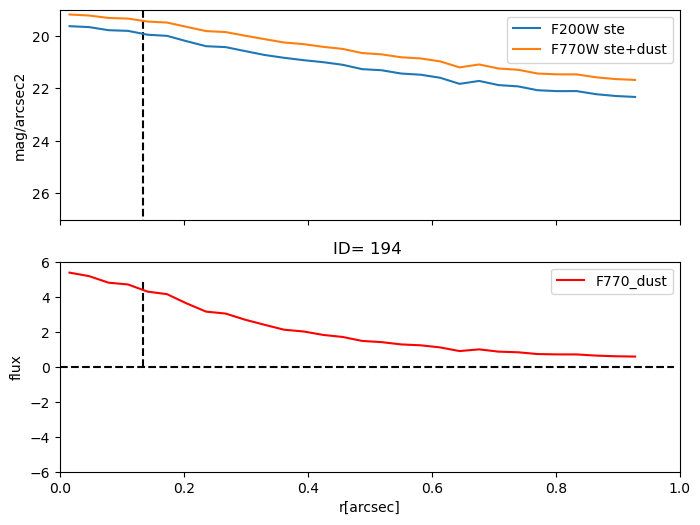

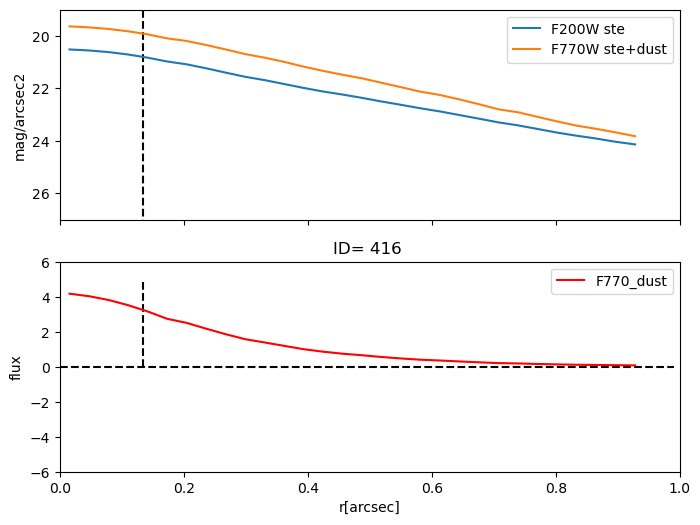

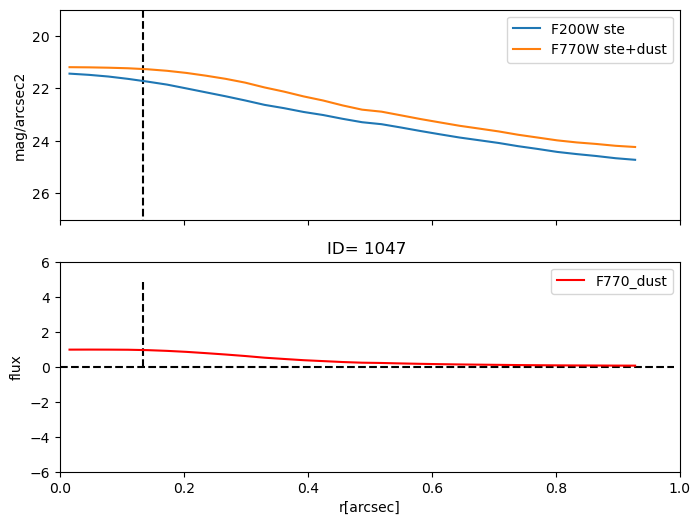

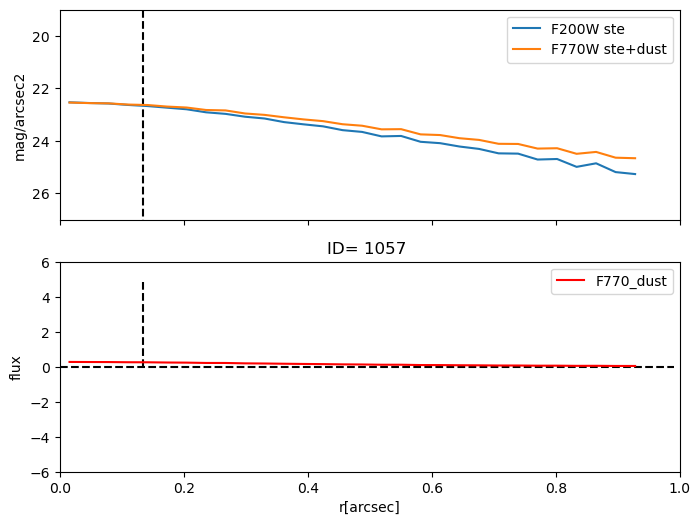

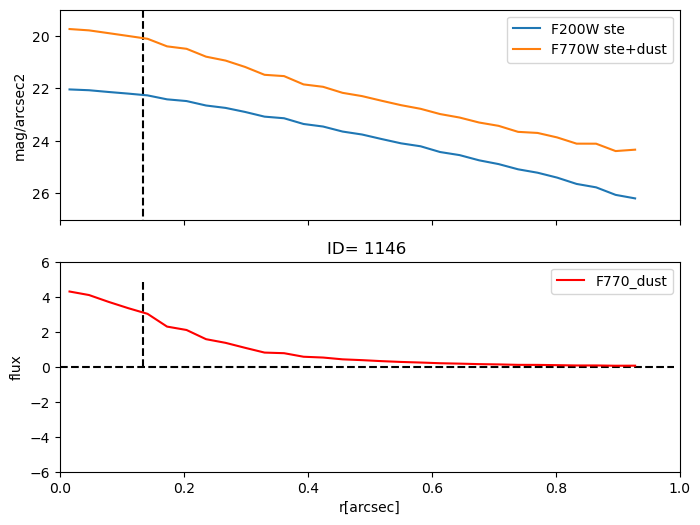

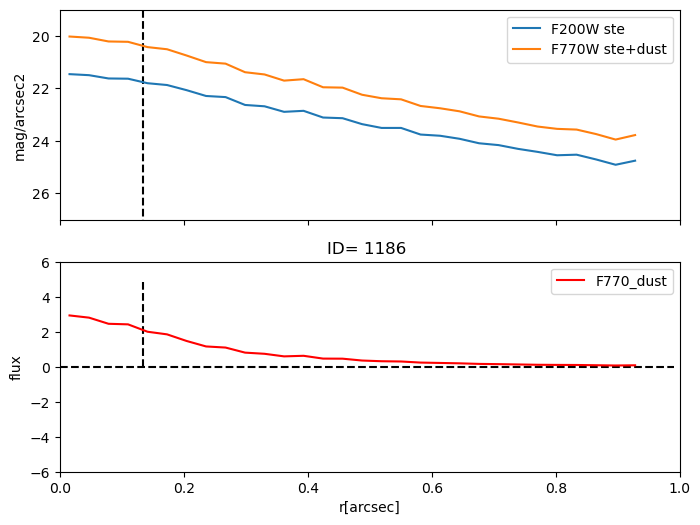

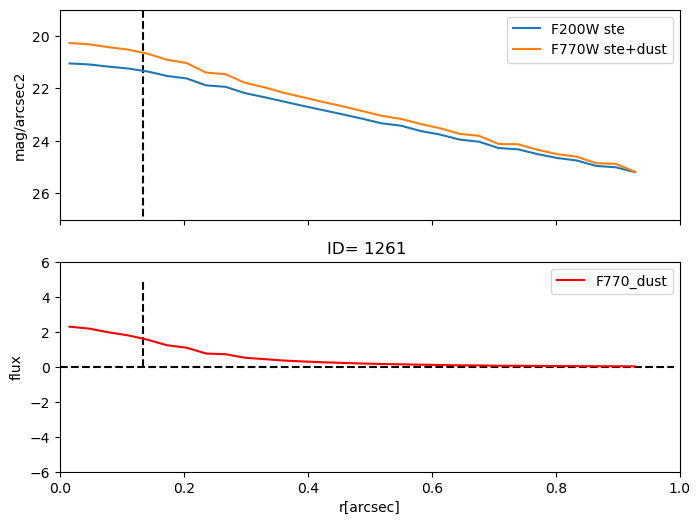

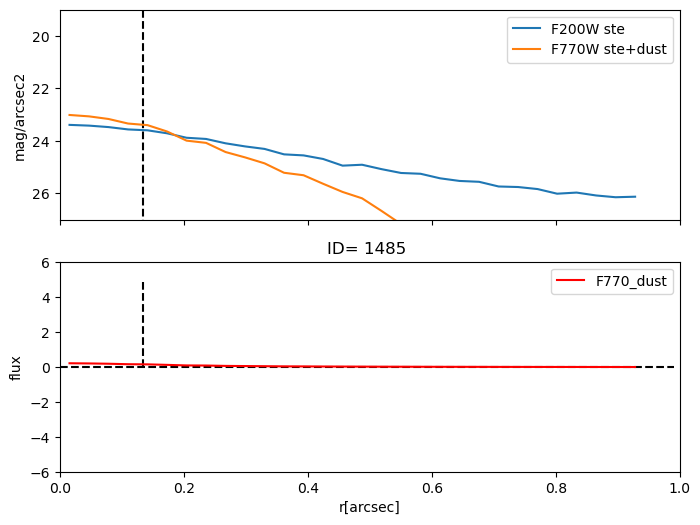

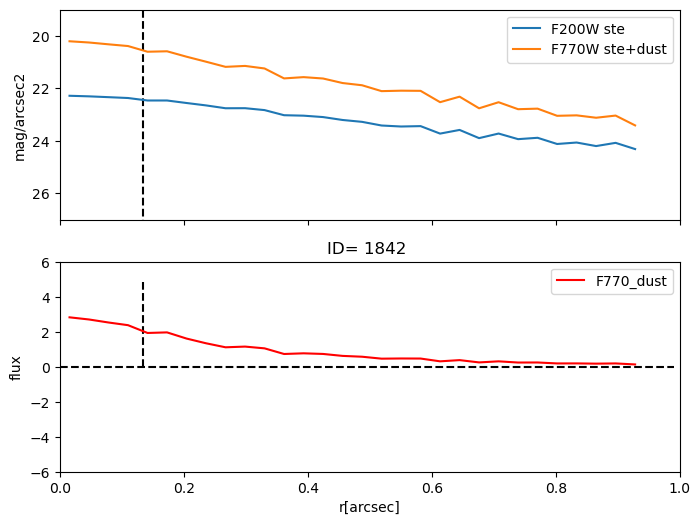

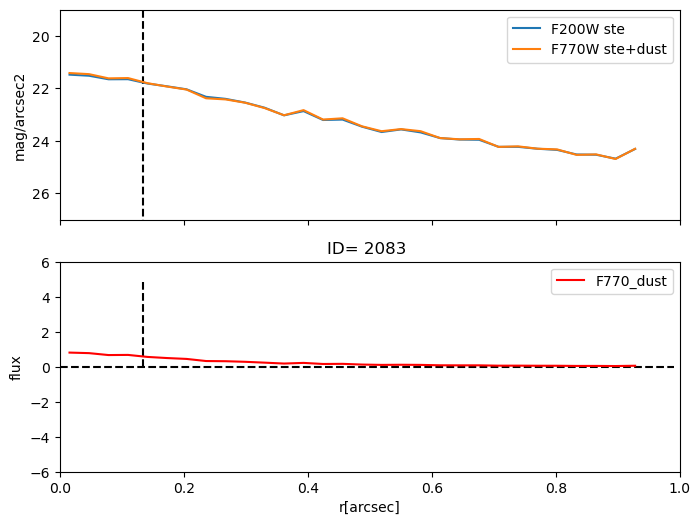

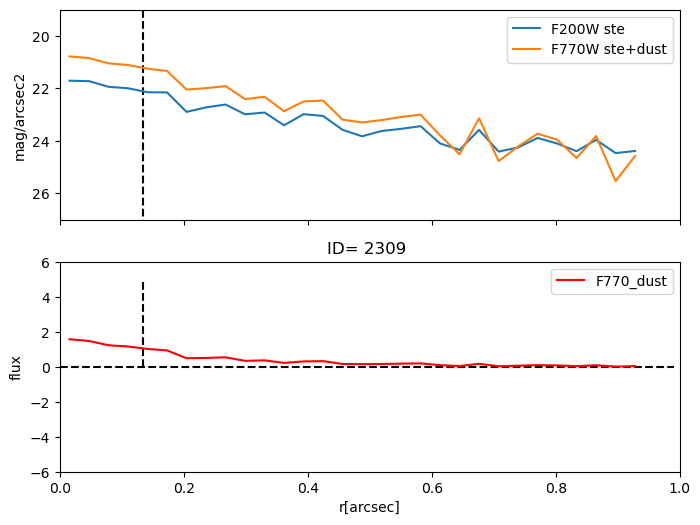

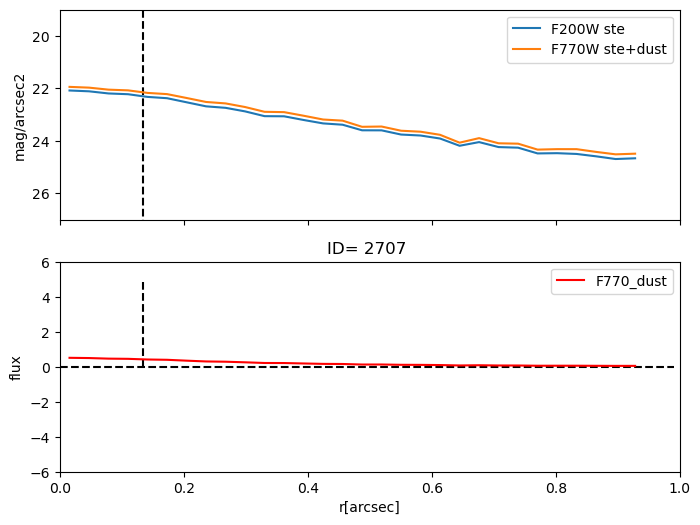

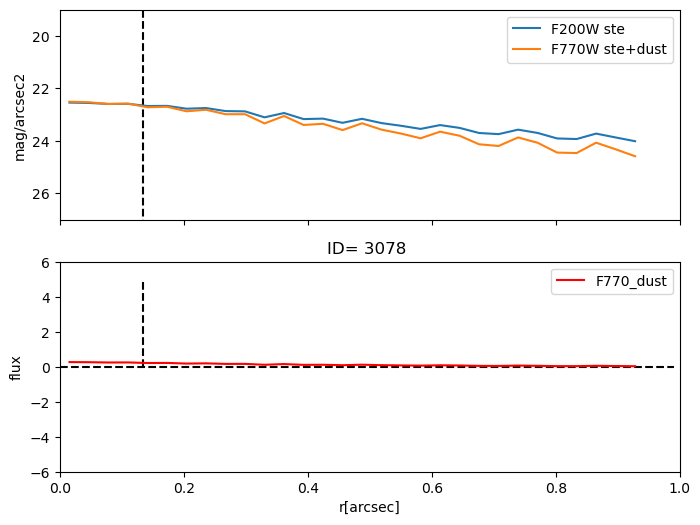

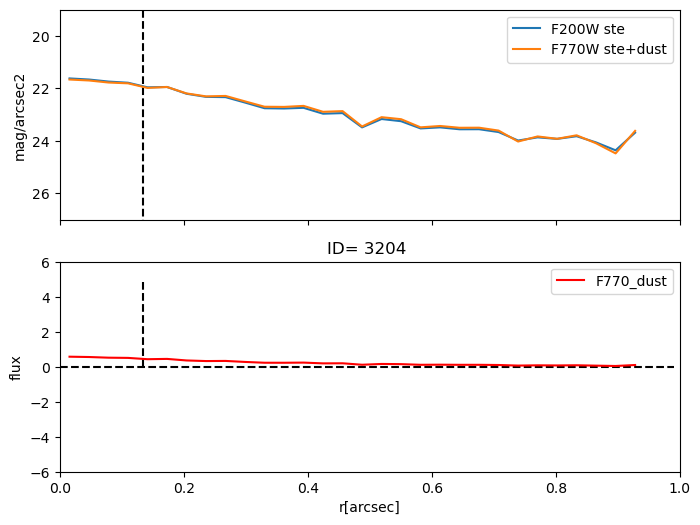

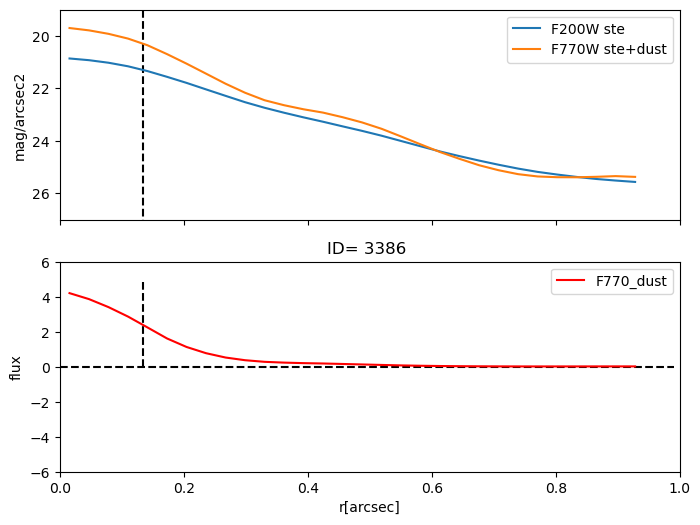

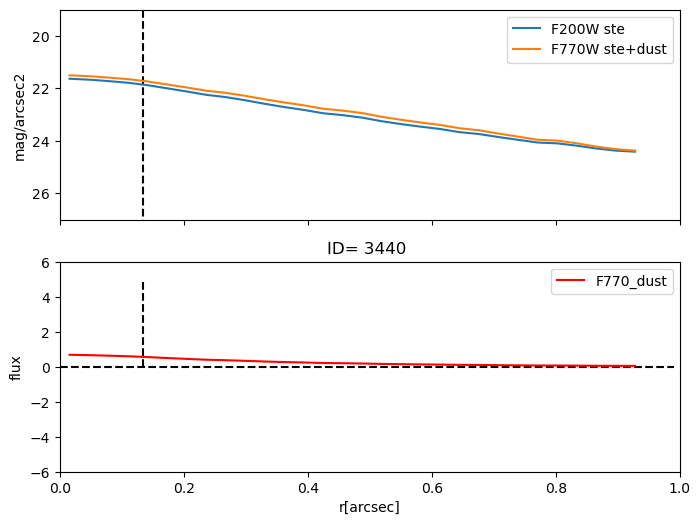

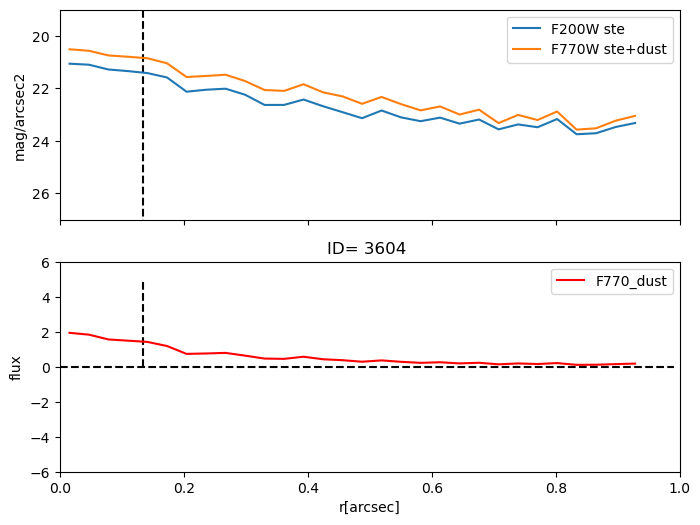

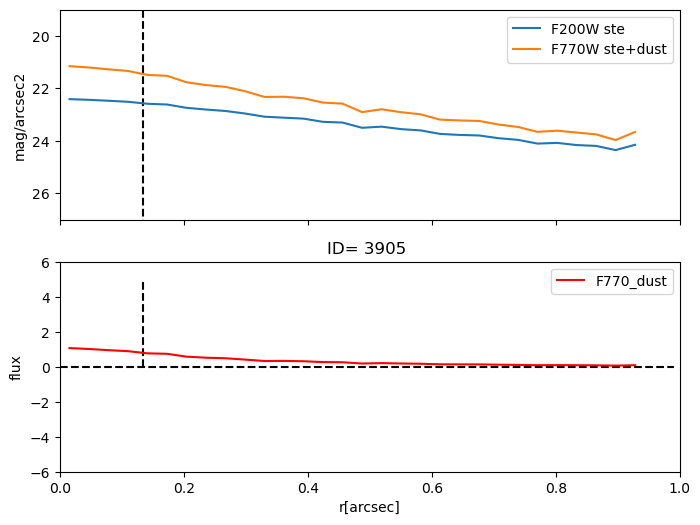

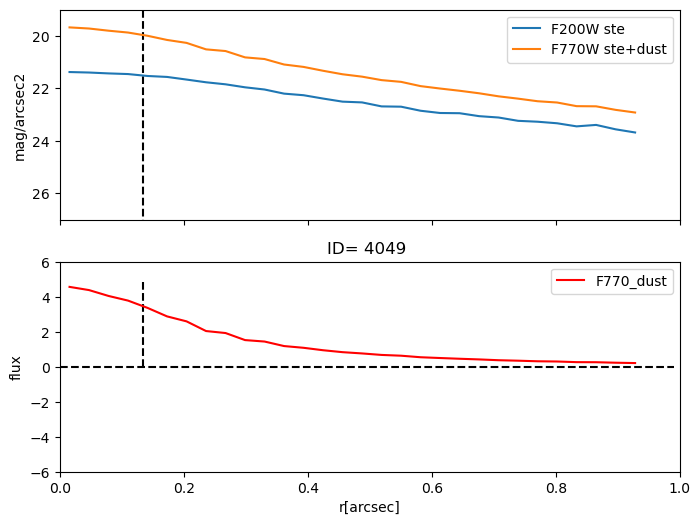

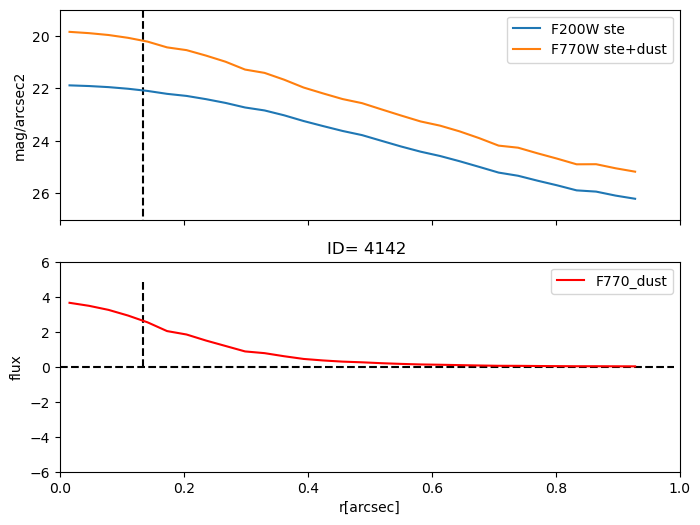

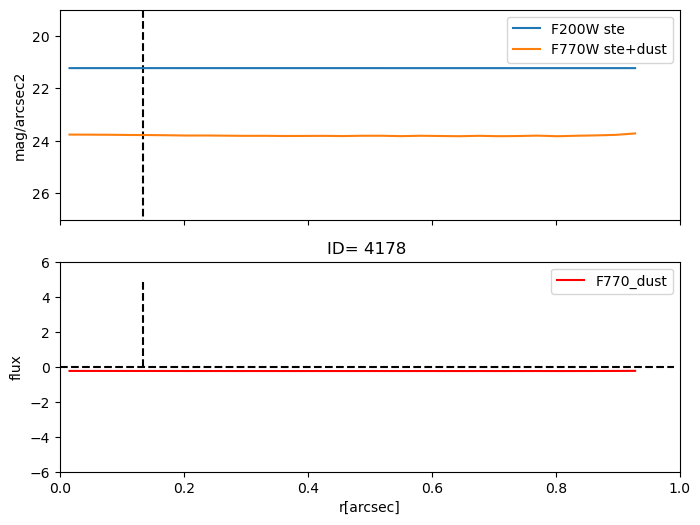

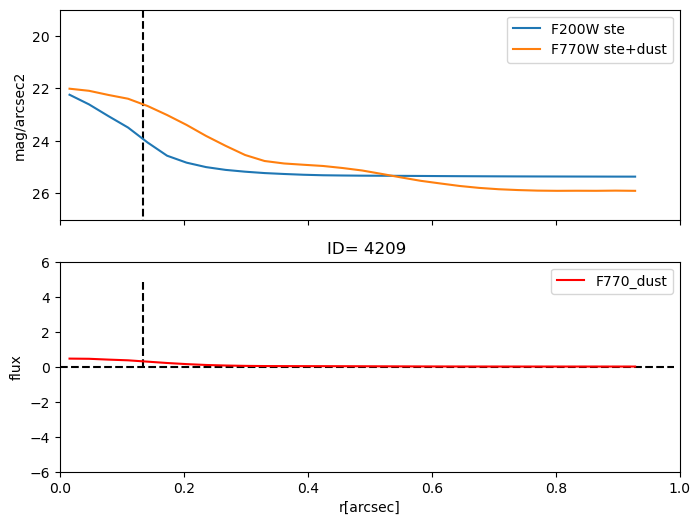

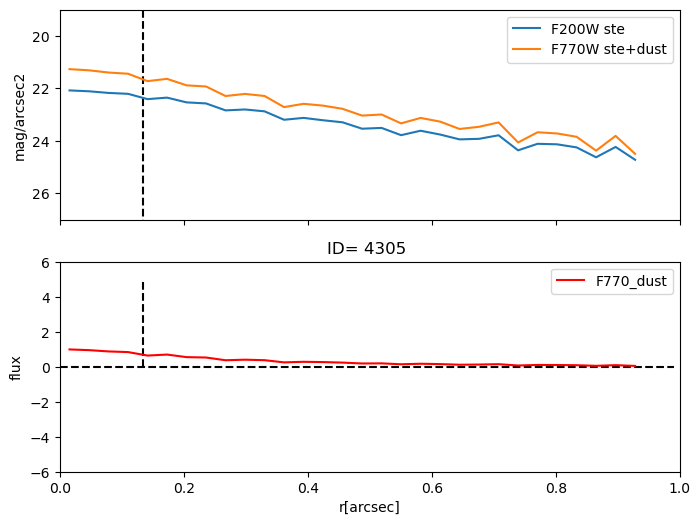

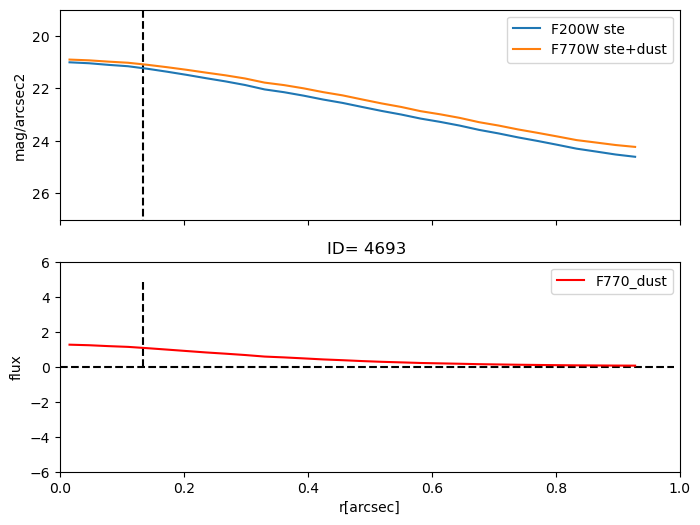

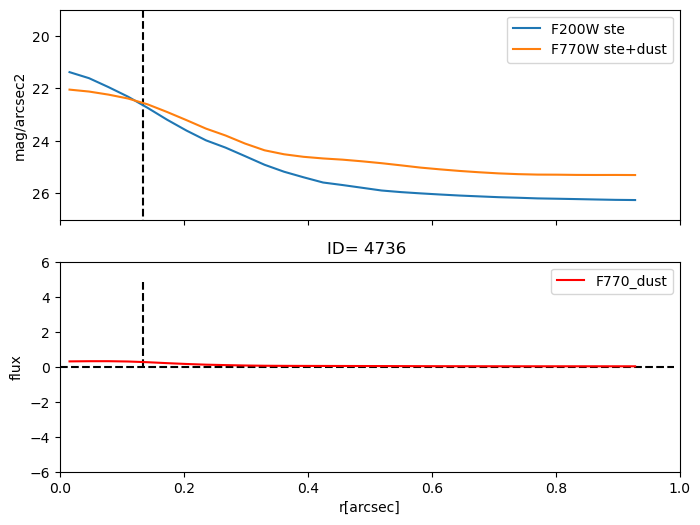

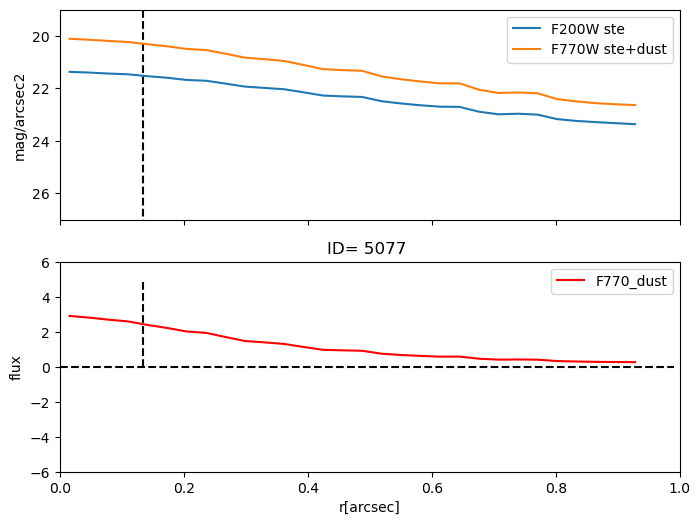

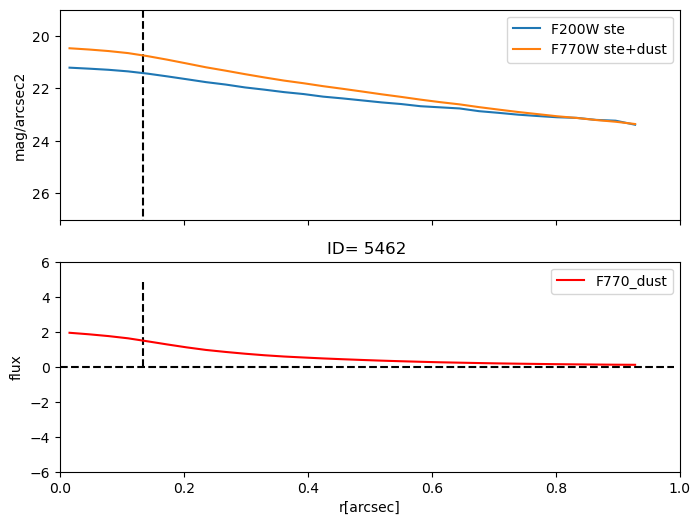

In [294]:
in_total_ratio_dust_galfit = []
in_total_ratio_dust_err_galfit = []
in_total_ratio_stellar_galfit = []
in_total_ratio_stellar_err_galfit = []
test_pixel_galfit = []
test_outer_pixel_galfit = []
for k in range(len(data)):
#for k in range(1):
    #k = 7
    nircam200_all = sorted(glob.glob('/Users/liuzhaoran/Desktop/miri/galfit/output/out_image_200to770/*out_200.fits'))
    miri770_all = sorted(glob.glob('/Users/liuzhaoran/Desktop/miri/galfit/output/out_image_f770W/*_out_770.fits'))
    ext = 2
    gal_200 = nircam200_all[k]
    gal_770 = miri770_all[k]
    gal_1000 = miri1000_all[k]
    hd0_gal_200 = fits.open(gal_200)[0].header
    hd0_gal_770 = fits.open(gal_770)[0].header
    
    
    
    #@@@ If you do not have the following, find out from e.g., SExtractor catalog. 

    # xcen = float(hd_gal['2_XC'].split(' ')[0])
    # ycen = float(hd_gal['2_YC'].split(' ')[0])
    xcen = float(50.0)
    ycen = float(50.0)
    # rst = int(hd_gal['NAXIS1'])
    #q = float(hd_gal['2_AR'].split(' ')[0])
    #pa = float(hd_gal['2_PA'].split(' ')[0])
    # delr = 1.0
    rst = int(100)
    q = data['b_image_JWST_NIRCAM_MULTIPLE_F200W'][k]/data['a_image_JWST_NIRCAM_MULTIPLE_F200W'][k]
    pa_200 = data['theta_JWST_NIRCAM_MULTIPLE_F200W'][k]
#     pa_770 = data['theta_1000'][k]
#     pa_1000 =data['theta_1000'][k]
    delr = 1

    # pa_200 = pa_200 + 90
    r_200, f_200 = radial2(gal_200, ext, xcen, ycen, rst, q, pa_200, delr=delr, rmax=30, norm=False)
    r_770, f_770 = radial2(gal_770, ext, xcen, ycen, rst, q, pa_200, delr=delr, rmax=30, norm=False)
    # gal_200 = '2707_rms_200_100_100.fits'
    # gal_770 = '2707_rms_770_100_100.fits'
    # gal_1000 = '2707_rms_1000_100_100.fits'
  
    
    
    magzp_200 = 28.000411294150283
    magzp_770 = 28.902822029188933 
    fig, axes = plt.subplots(nrows=2,ncols=1,sharex=True,figsize=(8,6)) 
    # add a subplot with no frame
    #ax2 = plt.subplot(222, frameon=False)
    axes1= axes[0]
    axes2= axes[1]

    #plt.yscale("log")
    pix_200 = 0.031456 # pixel scale
    area_200 = pix_200**2 # arcsec2
    pix_770 = 0.031456 # pixel scale
    area_770 = pix_770**2 # arcsec2
    pix_1000 = 0.031456 # pixel scale
    area_1000 = pix_1000**2 # arcsec2
    #f_phys_200 = -2.5*np.log10(f_200 / area) + 28.000411294150283# mag / arcsec2
    f_dust_770 = f_770 - f_200/ratio_2_7[k]
    f_dust_1000 = f_1000 - f_200/ratio_2_10[k]
    f_phys_200 = -2.5*np.log10(f_200 / area_200) + 28.000411294150283
    f_phys_770 = -2.5*np.log10(f_770 / area_770) + 28.902822029188933 
    f_phys_1000 = -2.5*np.log10(f_1000 / area_1000) + 28.902822029188933 

    ###error###
    f_dust_770_r = np.sqrt(ef_770**2 + ef_200**2/(ratio_2_7[k]**2))
    f_dust_1000_r = np.sqrt(ef_1000**2 + ef_200**2/(ratio_2_10[k]**2))


    sn_200 = np.abs(f_200) / np.abs(ef_200)
    ef_phys_200 = 1/sn_200 # mag / arcsec2
    sn_770 = np.abs(f_770) / np.abs(ef_770)
    ef_phys_770 = 1/sn_770 # mag / arcsec2
    sn_1000 = np.abs(f_1000) / np.abs(ef_1000)
    ef_phys_1000 = 1/sn_1000 # mag / arcsec2
    axes1.errorbar(r_200*0.031456, f_phys_200 , label = 'F200W ste')
    axes1.errorbar(r_770*0.031456, f_phys_770 , label = 'F770W ste+dust')
 #   axes1.errorbar(r_1000*0.0251, f_phys_1000 , yerr= 0.5*ef_phys_1000, label = 'F1000W ste+dust')
    #plt.errorbar(r_770*0.0251, f_phys_1000 , yerr= ef_phys_1000, label = 'F1000W ste+dust')
    axes2.errorbar(r_770*0.031456, f_dust_770 ,label = 'F770_dust', color = 'red')
    #axes2.errorbar(r_770*0.0251, f_dust_1000 , yerr= f_dust_1000_r,label = 'F1000_dust', color = 'purple')
    #axes2.errorbar(r_770*0.0251, f_200 , yerr=0.5* ef_200,label = 'F200_stellar', color = 'black')
  #  axes1.plot([0.328, 0.328], [15,30] ,'--',color = 'black')
    axes1.plot([0.269/2, 0.269/2], [15,30] ,'--',color = 'black')
   # axes2.plot([0.328, 0.328], [0,5] ,'--',color = 'black')
    axes2.plot([0.269/2, 0.269/2], [0,5] ,'--',color = 'black')
    #plt.errorbar(r_770*0.04, f_phys_770 , yerr= ef_phys_770, label = 'F770W ste+dust')
    #plt.errorbar(r_1000*0.04, f_phys_1000, yerr= ef_phys_1000, label = 'F1000W')
    #plt.errorbar(np.log10(r_770), f_phys_770-f_phys_200, yerr=ef_phys_770, label = 'F770W')
    axes2.set_xlabel('r[arcsec]')
    axes2.set_ylabel('flux')
    axes1.set_ylabel('mag/arcsec2')
    axes1.set_ylim(27, 19)
    #axes1.set_ylim(38, 18)
    axes2.set_ylim(-6, 6)
    xx = np.arange(0, 1, 0.01)
    axes2.plot(xx, xx*0 ,'--',color = 'black')
    title = "ID= %s " %(data['idalp'][k])
    plt.title(title)

    plt.xlim(0, 1)
    axes2.legend()
    axes1.legend()
    
    
    for j in range(len(r_200)):
        if f_dust_770[j] <=0:
            f_dust_770[j] = 0
        if f_200[j] <= 0:
            f_200[j] = 0
    
    ###Correct for redshift effect and lensing magnification###
    ####denination of inner region: 1kpc, trace the bulge formation###
    d_A = cosmo.angular_diameter_distance(z=data['zbest'][k]).value
    theta = 1/1000/d_A/pi * 180 * 3600*data['magnification'][k]
    pixel = theta/0.031456
    inner_region_pixel = math.ceil(pixel)
    test_pixel_galfit.append(inner_region_pixel)
    
    #calculate the flux ratio in 10 pixels and out 10 pixels
    #here is the flux! not flux density!
    fluxdust_total_in = []
    fluxstellar_total_in = []
    area = []
    for i in range(inner_region_pixel):
        r1 = r_200[i]
        r2 = r_200[i]*q
        r_e_2 = r1*r2
        if i == 0:
            flux_circle = f_dust_770[i]*pi*r_e_2
            flux_circle_stellar = f_200[i]*pi*r_e_2
        else:
            r1_o = r_200[i-1]
            r2_o = r_200[i-1]*q
            r_e_2_o = r1_o*r2_o
            flux_circle = f_dust_770[i]*pi*r_e_2 - f_dust_770[i]*pi*r_e_2_o
            flux_circle_stellar = f_200[i]*pi*r_e_2 - f_200[i]*pi*r_e_2_o
        fluxdust_total_in.append(flux_circle)
        fluxstellar_total_in.append(flux_circle_stellar)
        
    #r = np.sqrt(data['b_image_JWST_NIRCAM_MULTIPLE_F200W'][i]*data['a_image_JWST_NIRCAM_MULTIPLE_F200W'][i])
    #calculate the flux ratio in 10 pixels and out 10 pixels
    fluxdust_total = []
    fluxstellar_total = []
    outer_pixel = outer_pixel_2D[k]
    test_outer_pixel_galfit.append(outer_pixel )
    #outer_pixel = outer_pixel_2D[0]
    for i in range(outer_pixel):
        r1 = r_200[i]
        r2 = r_200[i]*q
        r_e_2 = r1*r2
        if i == 0:
            flux_circle = f_dust_770[i]*pi*r_e_2
            flux_circle_stellar = f_200[i]*pi*r_e_2
        else:
            r1_o = r_200[i-1]
            r2_o = r_200[i-1]*q
            r_e_2_o = r1_o*r2_o
            flux_circle = f_dust_770[i]*pi*r_e_2- f_dust_770[i]*pi*r_e_2_o
            flux_circle_stellar = f_200[i]*pi*r_e_2 - f_200[i]*pi*r_e_2_o
        fluxdust_total.append(flux_circle)
        fluxstellar_total.append(flux_circle_stellar)
        
        
    flux_total_in_normalize_dust = np.sum(fluxdust_total_in)
    flux_total_normalize_dust = np.sum(fluxdust_total)
    flux_total_in_normalize_stellar = np.sum(fluxstellar_total_in)
    flux_total_normalize_stellar = np.sum(fluxstellar_total)

    
    in_total_ratio_dust_galfit.append(flux_total_in_normalize_dust/flux_total_normalize_dust)
    in_total_ratio_stellar_galfit.append( flux_total_in_normalize_stellar/flux_total_normalize_stellar)
    

In [295]:
in_total_ratio_dust_galfit = np.array(in_total_ratio_dust_galfit)
in_total_ratio_stellar_galfit = np.array(in_total_ratio_stellar_galfit)


in_total_ratio_dust_2d = np.array(in_total_ratio_dust_2d )
in_total_ratio_dust_err_2d = np.array(in_total_ratio_dust_err_2d )
in_total_ratio_stellar_2d = np.array(in_total_ratio_stellar_2d )
in_total_ratio_stellar_err_2d = np.array(in_total_ratio_stellar_err_2d )


index_close = np.arange(20, 22 , 1, dtype = None)

In [296]:
compactness_dust_stellar_2D = in_total_ratio_dust_2d/in_total_ratio_stellar_2d
compactness_dust_stellar_galfit =in_total_ratio_dust_galfit/in_total_ratio_stellar_galfit
e_compactness_dust_stellar_2D = compactness_dust_stellar_2D * np.sqrt((in_total_ratio_stellar_err_2d/in_total_ratio_stellar_2d)**2
                                                                     +(in_total_ratio_dust_err_2d/in_total_ratio_dust_2d)**2)

In [297]:
stellar_ratio_2d_galfit = np.array(in_total_ratio_stellar_2d) /np.array(in_total_ratio_stellar_galfit)
dust_ratio_2d_galfit = np.array(in_total_ratio_dust_2d) /np.array(in_total_ratio_dust_galfit)

In [299]:
data[np.where(e_compactness_dust_stellar_2D>=0.4)[0]]

<Table length=3>
idalp lowz_dust PAH_flag ... FLUXERR_BEST_1800 MAG_BEST_1800 MAGERR_BEST_1800
int64   int64    int64   ...      float64         float64        float64     
----- --------- -------- ... ----------------- ------------- ----------------
 1485         0        1 ...          6.747299       23.8065           0.0671
 3604         0        1 ...          397.8674       20.1819           0.1403
 4305         0        1 ...          20.10165        21.132            0.017

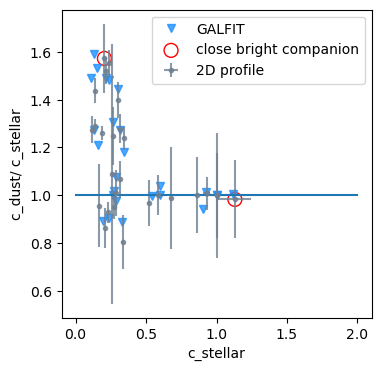

In [300]:

fig, axes = plt.subplots(nrows=1,ncols=1,sharex=True,figsize=(4,4)) 
#plt.xscale("log")
#plt.yscale("log")
mplt.plot(in_total_ratio_stellar_galfit, compactness_dust_stellar_galfit,'v', c = 'dodgerblue', label = 'GALFIT', alpha = 0.8)
mplt.errorbar(in_total_ratio_stellar_2d, compactness_dust_stellar_2D,xerr = in_total_ratio_stellar_err_2d/2, yerr = e_compactness_dust_stellar_2D/2,fmt ='.',c='slategrey', label = '2D profile', alpha = 0.8)
mplt.scatter(in_total_ratio_stellar_2d[index_close], compactness_dust_stellar_2D[index_close],color='none', marker = 'o', edgecolors = 'r', s = 100, label = 'close bright companion')










#mplt.plot(in_out_ratio_stellar, in_out_ratio_dust, 'o', label = 'Lenstruction')
mplt.xlabel('c_stellar')
mplt.ylabel('c_dust/ c_stellar')
#mplt.xlim(0.3,20)
mplt.plot([0,2], [1, 1])
mplt.legend()

In [301]:
np.min(np.log(sed['best.stellar.m_star']))

19.620191149055845

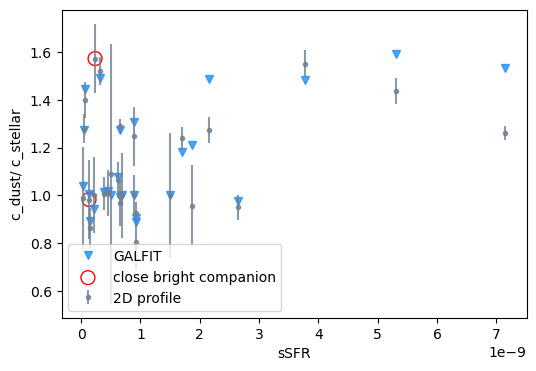

In [302]:

fig, axes = plt.subplots(nrows=1,ncols=1,sharex=True,figsize=(6,4)) 
#plt.xscale("log")
#plt.yscale("log")
ssfr = sed['best.sfh.sfr']/sed['best.stellar.m_star']
mplt.plot(ssfr, compactness_dust_stellar_galfit,'v', c = 'dodgerblue', label = 'GALFIT', alpha = 0.8)
mplt.errorbar(ssfr, compactness_dust_stellar_2D,yerr = e_compactness_dust_stellar_2D/2,fmt ='.',c='slategrey', label = '2D profile', alpha = 0.8)
mplt.scatter(ssfr[index_close], compactness_dust_stellar_2D[index_close],color='none', marker = 'o', edgecolors = 'r', s = 100, label = 'close bright companion')



#mplt.plot(in_out_ratio_stellar, in_out_ratio_dust, 'o', label = 'Lenstruction')
mplt.xlabel('sSFR')
mplt.ylabel('c_dust/ c_stellar')
#mplt.xlim(0.3,20)
#mplt.plot([0,2], [1, 1])
mplt.legend()

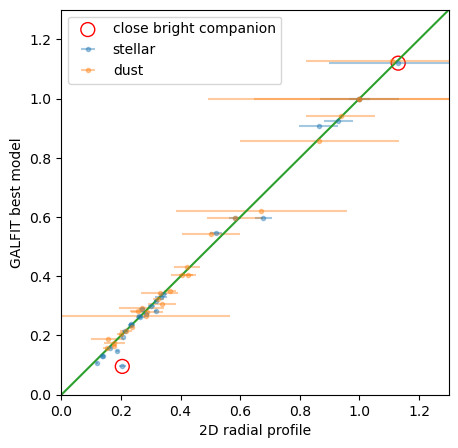

In [303]:

fig, axes = plt.subplots(nrows=1,ncols=1,sharex=True,figsize=(5,5)) 

mplt.errorbar(np.array(in_total_ratio_stellar_2d), np.array(in_total_ratio_stellar_galfit), xerr = in_total_ratio_stellar_err_2d,fmt = '.', alpha = 0.4, label = 'stellar')
mplt.errorbar(np.array(in_total_ratio_dust_2d), np.array(in_total_ratio_dust_galfit), xerr = in_total_ratio_dust_err_2d,fmt = '.', alpha = 0.4, label = 'dust')
mplt.scatter(np.array(in_total_ratio_stellar_2d)[index_close], 
             np.array(in_total_ratio_stellar_galfit)[index_close],  color='none', marker = 'o', edgecolors = 'r', s = 100, label = 'close bright companion')

mplt.xlabel('2D radial profile')
mplt.ylabel('GALFIT best model')
mplt.plot([0,1.3], [0, 1.3])
mplt.xlim(0,1.3)
mplt.ylim(0,1.3)
mplt.legend()

In [72]:
in_total_ratio_stellar_2d, in_total_ratio_stellar_galfit

([0.35254552384870597], [0.289421794652536])

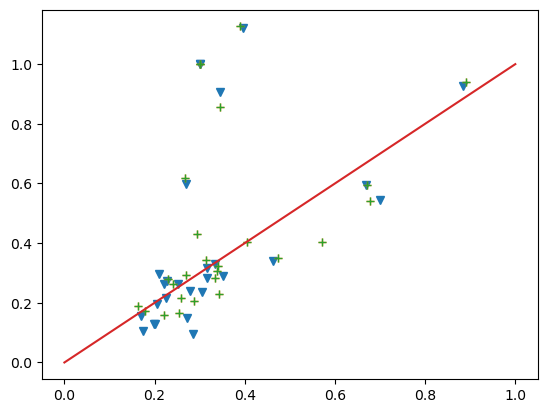

In [106]:
mplt.plot(in_total_ratio_stellar_2d, in_total_ratio_stellar_galfit, 'v', label = 'stellar')
mplt.plot(in_total_ratio_dust_2d, in_total_ratio_dust_galfit, '+', label = 'dust')
#mplt.scatter(np.array(in_total_ratio_stellar_2d)[index_marker], np.array(in_total_ratio_stellar_galfit)[index_marker], color='none', marker = 'o', edgecolors = 'r', s = 200)
#mplt.scatter(np.array(in_total_ratio_dust_2d)[index_marker], np.array(in_total_ratio_dust_galfit)[index_marker], color='none', marker = 'o', edgecolors = 'r', s = 200)
mplt.plot(in_total_ratio_dust_2d, in_total_ratio_dust_galfit, '+')
mplt.plot([0,1], [0, 1])

/var/folders/kl/kvr8wgvd6_z3gsnb2p117kwh0000gn/T/ipykernel_5158/3014008940.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1=plt.subplot(441)
/var/folders/kl/kvr8wgvd6_z3gsnb2p117kwh0000gn/T/ipykernel_5158/3014008940.py:56: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2=plt.subplot(442)
/var/folders/kl/kvr8wgvd6_z3gsnb2p117kwh0000gn/T/ipykernel_5158/3014008940.py:63: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3=plt.subplot(443)
/var/folders/kl/kvr8wgvd6_z3gsnb2p117kwh0000gn/T/ipykernel_5158/3014008940.py:70: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 

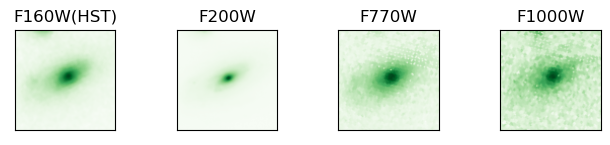

id:194, log_m = 10.87 M*, SFR = 11.017 M*/yr, c_2d = 0.862, c_galfit= 0.892,


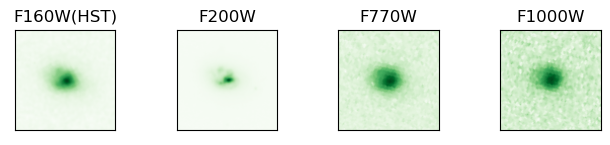

id:416, log_m = 10.13 M*, SFR = 8.452 M*/yr, c_2d = 1.066, c_galfit= 1.075,


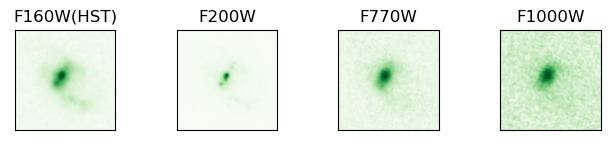

id:1047, log_m = 9.5 M*, SFR = 8.418 M*/yr, c_2d = 0.95, c_galfit= 0.976,


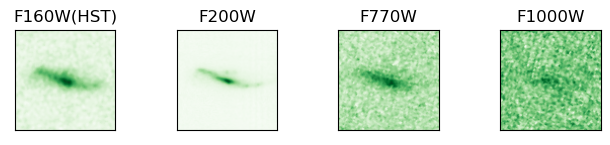

id:1057, log_m = 9.11 M*, SFR = 1.205 M*/yr, c_2d = 0.804, c_galfit= 0.887,


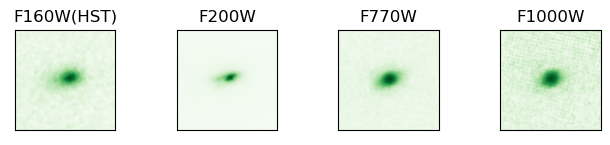

id:1146, log_m = 9.66 M*, SFR = 17.55 M*/yr, c_2d = 1.551, c_galfit= 1.481,


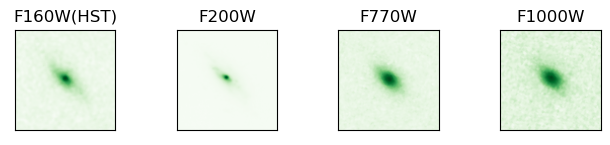

id:1186, log_m = 10.04 M*, SFR = 18.979 M*/yr, c_2d = 1.239, c_galfit= 1.181,


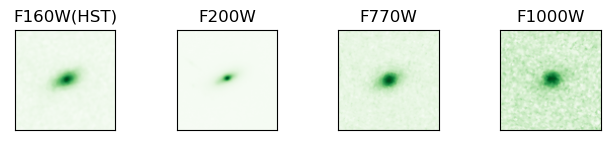

id:1261, log_m = 10.12 M*, SFR = 0.726 M*/yr, c_2d = 1.278, c_galfit= 1.273,


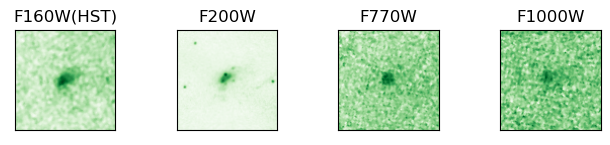

id:1485, log_m = 8.52 M*, SFR = 0.495 M*/yr, c_2d = 1.0, c_galfit= 1.0,


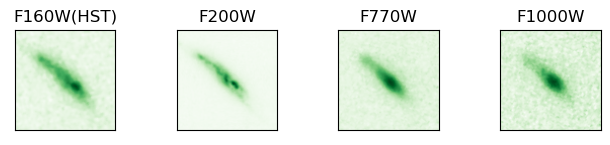

id:1842, log_m = 9.54 M*, SFR = 18.706 M*/yr, c_2d = 1.437, c_galfit= 1.59,


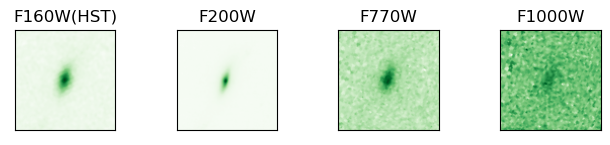

id:2083, log_m = 9.46 M*, SFR = 1.333 M*/yr, c_2d = 1.009, c_galfit= 1.017,


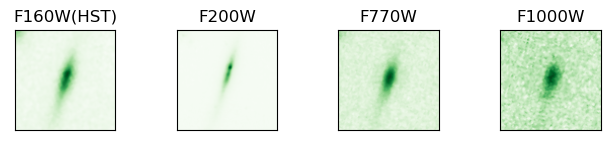

id:2309, log_m = 9.37 M*, SFR = 0.931 M*/yr, c_2d = 1.008, c_galfit= 1.015,


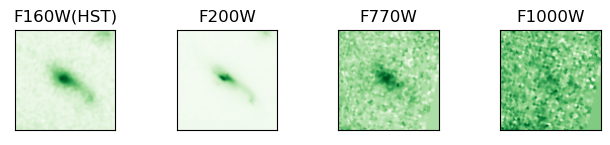

id:2707, log_m = 9.23 M*, SFR = 1.205 M*/yr, c_2d = 1.0, c_galfit= 1.0,


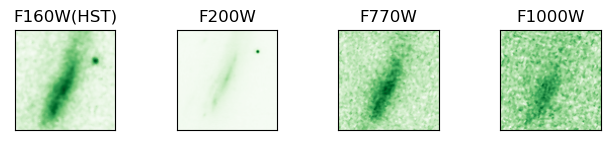

id:3078, log_m = 9.66 M*, SFR = 8.569 M*/yr, c_2d = 0.956, c_galfit= 1.21,


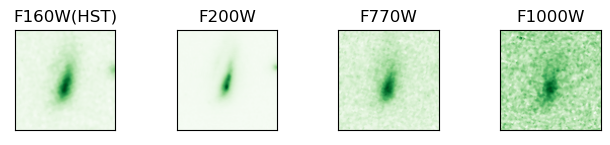

id:3204, log_m = 9.41 M*, SFR = 1.69 M*/yr, c_2d = 0.967, c_galfit= 0.995,


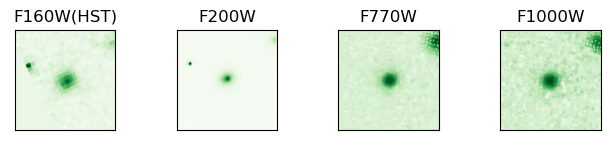

id:3386, log_m = 10.15 M*, SFR = 0.914 M*/yr, c_2d = 1.397, c_galfit= 1.444,


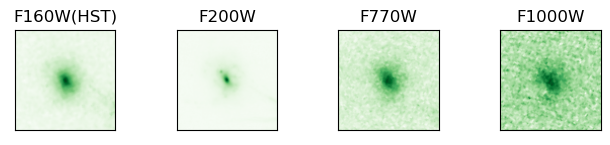

id:3440, log_m = 9.44 M*, SFR = 2.472 M*/yr, c_2d = 1.001, c_galfit= 1.0,


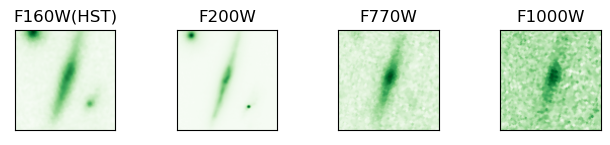

id:3604, log_m = 10.0 M*, SFR = 5.087 M*/yr, c_2d = 1.09, c_galfit= 1.0,


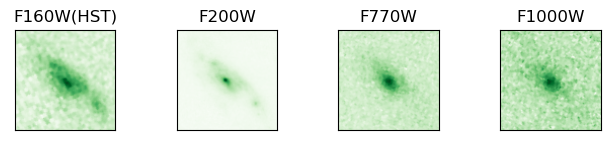

id:3905, log_m = 9.76 M*, SFR = 5.19 M*/yr, c_2d = 1.247, c_galfit= 1.306,


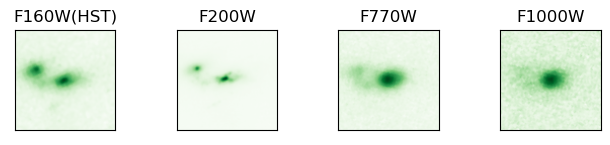

id:4049, log_m = 9.59 M*, SFR = 27.857 M*/yr, c_2d = 1.261, c_galfit= 1.533,


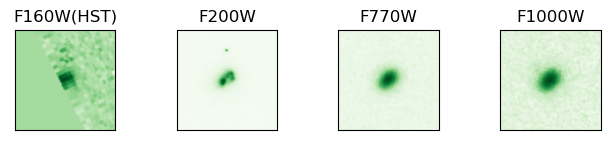

id:4142, log_m = 10.31 M*, SFR = 6.608 M*/yr, c_2d = 1.521, c_galfit= 1.49,


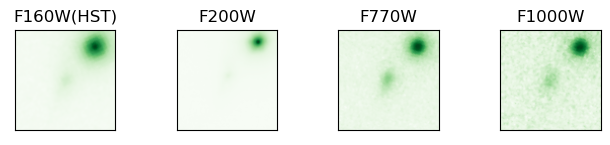

id:4178, log_m = 9.49 M*, SFR = 0.736 M*/yr, c_2d = 1.572, c_galfit= 0.0,


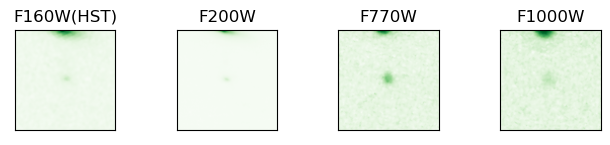

id:4209, log_m = 8.63 M*, SFR = 0.056 M*/yr, c_2d = 0.982, c_galfit= 1.005,


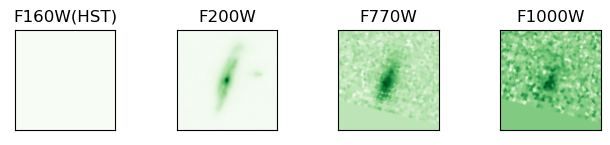

id:4305, log_m = 9.83 M*, SFR = 0.176 M*/yr, c_2d = 0.989, c_galfit= 1.037,


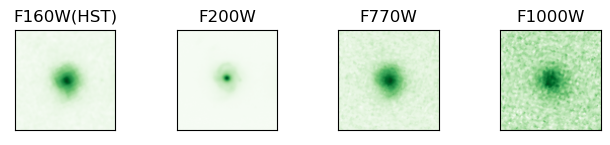

id:4693, log_m = 9.66 M*, SFR = 4.275 M*/yr, c_2d = 0.928, c_galfit= 0.905,


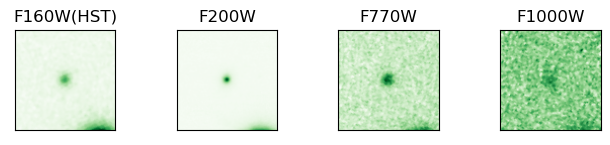

id:4736, log_m = 8.84 M*, SFR = 0.148 M*/yr, c_2d = 1.001, c_galfit= 0.943,


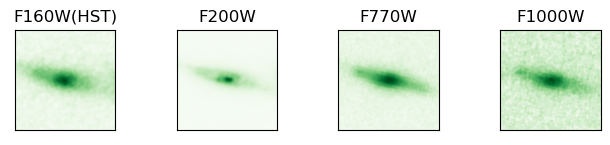

id:5077, log_m = 10.08 M*, SFR = 8.047 M*/yr, c_2d = 1.289, c_galfit= 1.274,


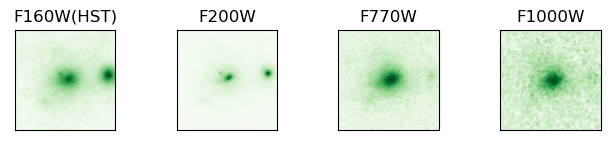

id:5462, log_m = 9.75 M*, SFR = 12.144 M*/yr, c_2d = 1.273, c_galfit= 1.489,


In [258]:
sci_200 = sorted(glob.glob('/Users/liuzhaoran/Desktop/miri/radial_profile/*200_100_100_sci.fits'))
sci_770 = sorted(glob.glob('/Users/liuzhaoran/Desktop/miri/radial_profile/*770_100_100_sci.fits'))
sci_1000 = sorted(glob.glob('/Users/liuzhaoran/Desktop/miri/radial_profile/*1000_100_100_sci.fits'))
sci_hst_160 = sorted(glob.glob('/Users/liuzhaoran/Desktop/miri/make_cut_out_for_highz/hst_160/*hst160_200_100_100_sci.fits'))


compactness_2d_dust_to_stellar = np.array(in_total_ratio_dust_2d)/np.array(in_total_ratio_stellar_2d)
compactness_galfit_dust_to_stellar = np.array(in_total_ratio_dust_galfit)/np.array(in_total_ratio_stellar_galfit)
compactness_galfit_dust_to_stellar[20] = 0
for k in range(len(compactness_2d_dust_to_stellar)):
    if compactness_galfit_dust_to_stellar[k] == 'nan':
        compactness_galfit_dust_to_stellar[k] = 0
        


for i in range(len(sci_200)):
    data_160=fits.open(sci_hst_160[i])
    data_200=fits.open(sci_200[i])
    data_770=fits.open(sci_770[i])
    data_1000=fits.open(sci_1000[i])
    dat_name=data['idalp'][i]
    stellar_mass = np.log10(sed['best.stellar.m_star'])[i]
    stellar_mass = int(stellar_mass * 100)/100
    c_2d = compactness_2d_dust_to_stellar[i]
    c_2d = int(c_2d * 1000)/1000
    c_galfit = compactness_galfit_dust_to_stellar[i]
    c_galfit = int(c_galfit * 1000)/1000
    
    sfr = sed['best.sfh.sfr'][i]
    sfr = int(sfr * 1000)/1000
    
    img_160 = data_160[0].data
    img_200 = data_200[0].data  # Image array
    img_770 = data_770[0].data
    img_1000 = data_1000[0].data
  #  res = data[3].data  # residual
    #Lets see the results
    fig, axes = plt.subplots(nrows=1,ncols=4,sharex=True,figsize=(8,6)) 
    # add a subplot with no frame
    #ax2 = plt.subplot(222, frameon=False)
    ax1= axes[0]
    ax2= axes[1]
    ax3= axes[2]
    ax4= axes[3]

  #  fig=plt.subplots_adjust(hspace=0.1, wspace=0.1,top=0.95, right=0.95)
    ax1=plt.subplot(441)
    #plot_img(ax1,img)
    
    ax1.imshow(np.arcsinh(img_160), cmap='Greens')

    plt.title('F160W(HST)')
    plt.xticks([],[])
    plt.yticks([],[])

    ax2=plt.subplot(442)
    ax2.imshow(np.arcsinh(img_200), cmap='Greens')
    #plot_img(ax2,mod)
    plt.title('F200W')
    plt.xticks([],[])
    plt.yticks([],[])
    
    ax3=plt.subplot(443)
    ax3.imshow(np.arcsinh(img_770), cmap='Greens')
    #plot_img(ax2,mod)
    plt.title('F770W')
    plt.xticks([],[])
    plt.yticks([],[])
    
    ax4=plt.subplot(444)
    ax4.imshow(np.arcsinh(img_1000), cmap='Greens')
    #plot_img(ax2,mod)
    plt.title('F1000W')
    plt.xticks([],[])
    plt.yticks([],[])

  #  ax3=plt.subplot(333)
    #plot_img(ax3,res)
   # plt.imshow(np.arcsinh(res), cmap='Greys')
    plt.xticks([],[])
    plt.yticks([],[])
    plt.show()
    #remove_figure(fig)
    print(f'id:{dat_name}'',', f'log_m = {stellar_mass} M*'',',f'SFR = {sfr} M*/yr'',',
          f'c_2d = {c_2d}'',', f'c_galfit= {c_galfit}'',')

In [22]:
cd/cs

0

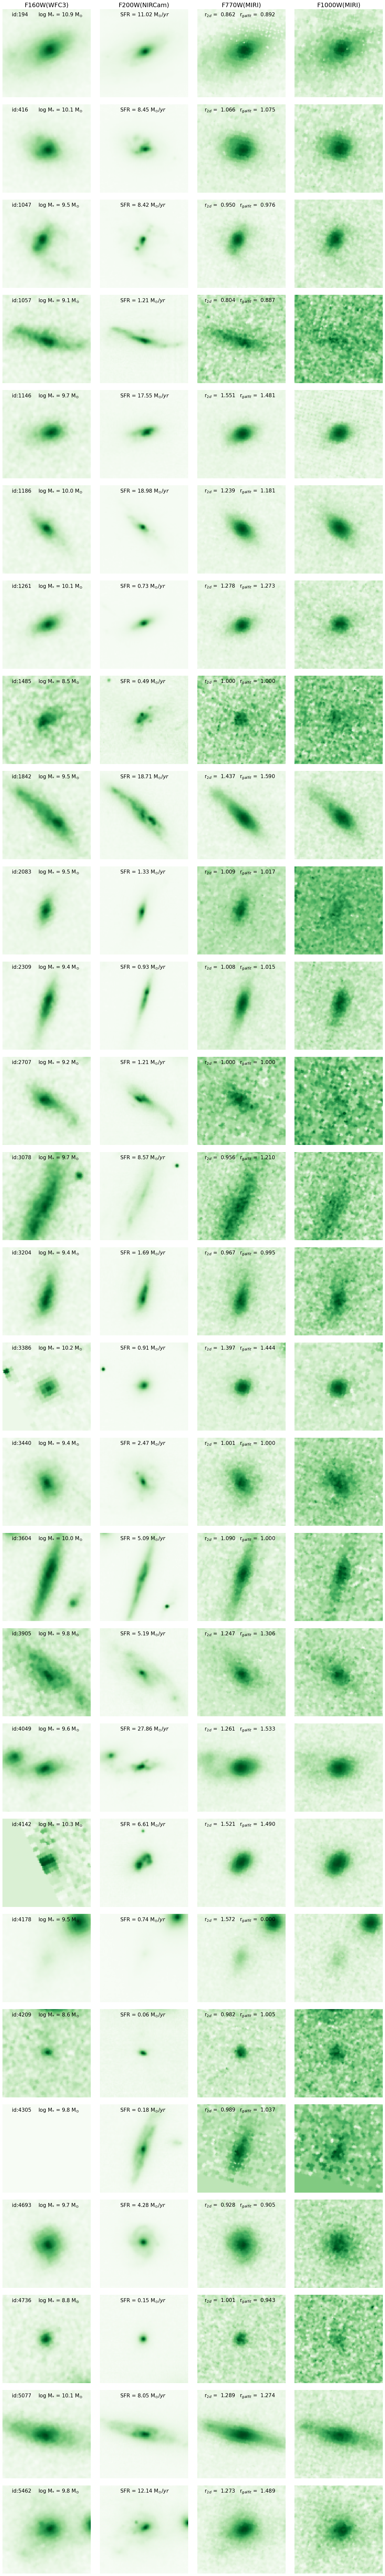

In [384]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import glob

# Set main title



# Loop over all images and create subplots
fig, axes = plt.subplots(nrows=len(sci_200), ncols=4, figsize=(20, 5*len(sci_200)))
fig.subplots_adjust(hspace=0.08, wspace=0.08)


for i in range(len(sci_200)):
    dat_name=data['idalp'][i]
    stellar_mass = np.log10(sed['best.stellar.m_star'])[i]
    stellar_mass = int(stellar_mass * 100)/100
    r_2d = compactness_2d_dust_to_stellar[i]
    r_2d = int(c_2d * 1000)/1000
    r_galfit = compactness_galfit_dust_to_stellar[i]
    r_galfit = int(c_galfit * 1000)/1000
    
    sfr = sed['best.sfh.sfr'][i]
    sfr = int(sfr * 1000)/1000
    # Open FITS files
    data_160 = fits.open(sci_hst_160[i])
    data_200 = fits.open(sci_200[i])
    data_770 = fits.open(sci_770[i])
    data_1000 = fits.open(sci_1000[i])
    
    # Get image data
    img_160 = data_160[0].data
    img_200 = data_200[0].data
    img_770 = data_770[0].data
    img_1000 = data_1000[0].data
    
    # Get metadata
    dat_name = data['idalp'][i]
    stellar_mass = np.log10(sed['best.stellar.m_star'])[i]
    stellar_mass = int(stellar_mass * 100) / 100
    c_2d = compactness_2d_dust_to_stellar[i]
    c_2d = int(c_2d * 1000) / 1000
    c_galfit = compactness_galfit_dust_to_stellar[i]
    c_galfit = int(c_galfit * 1000) / 1000
    sfr = sed['best.sfh.sfr'][i]
    sfr = int(sfr * 1000) / 1000
    
    # Plot images and add text labels
    ax1 = axes[i][0]
    ax1.imshow(np.arcsinh(img_160[10:90, 10:90]), cmap='Greens')
    ax1.text(8, 6, f'id:{dat_name}', fontsize=15, color="black")
    ax1.text(32, 6, 'log $\\mathdefault{{M_{{*}}}}$ = {:.1f} $\\mathdefault{{M}}_{{\\odot}}$'.format(stellar_mass), fontsize=15, color="black")
    ax1.axis('off')
    
    ax2 = axes[i][1]
    ax2.imshow(np.arcsinh(img_200[10:90, 10:90]), cmap='Greens')
    ax2.text(18, 6, 'SFR = {:.2f} $\\mathdefault{{M}}_{{\\odot}}/yr$'.format(sfr), fontsize=15, color="black")
    ax2.axis('off')
    
    ax3 = axes[i][2]
    ax3.imshow(np.arcsinh(img_770[10:90, 10:90]), cmap='Greens')
    ax3.text(6, 6, '$\\mathdefault{{r}}_{{2d}}$ =  {:.3f}'.format(c_2d), fontsize=15, color="black")
    ax3.text(38, 6, '$\\mathdefault{{r}}_{{galfit}}$ =  {:.3f}'.format(c_galfit), fontsize=15, color="black")
    ax3.axis('off')
    
    ax4 = axes[i][3]
    ax4.imshow(np.arcsinh(img_1000[10:90, 10:90]), cmap='Greens')
    ax4.axis('off')
    
    if i == 0:
        ax1.set_title('F160W(WFC3)', fontsize=18)
        ax2.set_title('F200W(NIRCam)', fontsize=18)
        ax3.set_title('F770W(MIRI)', fontsize=18)
        ax4.set_title('F1000W(MIRI)', fontsize=18)


In [364]:
c_2d

0.862